In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/portfolio-project-carecloud22222/project/project/CXR1524_IM-0339-2001.png
/kaggle/input/portfolio-project-carecloud22222/project/project/CXR2661_IM-1142-2001.png
/kaggle/input/portfolio-project-carecloud22222/project/project/CXR1474_IM-0307-2001.png
/kaggle/input/portfolio-project-carecloud22222/project/project/CXR3130_IM-1472-2001.png
/kaggle/input/portfolio-project-carecloud22222/project/project/CXR764_IM-2311-3001.png
/kaggle/input/portfolio-project-carecloud22222/project/project/CXR2623_IM-1111-1001.png
/kaggle/input/portfolio-project-carecloud22222/project/project/CXR1367_IM-0237-1001.png
/kaggle/input/portfolio-project-carecloud22222/project/project/CXR1907_IM-0589-2001.png
/kaggle/input/portfolio-project-carecloud22222/project/project/CXR3573_IM-1756-1001.png
/kaggle/input/portfolio-project-carecloud22222/project/project/CXR1617_IM-0399-1001.png
/kaggle/input/portfolio-project-carecloud22222/project/project/CXR1346_IM-0224-2001.png
/kaggle/input/portfolio-project-c

In [2]:
import os
import xml.etree.ElementTree as ET
from tqdm import tqdm

# Initialize lists to store the extracted data
png = []
indication = []
comparison = []
findings = []
impression = []

# Change the directory to where the XML files are stored
os.chdir(r'/kaggle/input/portfolio-project-carecloud22222/project reports/project reports/ecgen-radiology')
dir = os.listdir()

# Iterate over all files in the directory
for file in tqdm(dir):
    try:
        # Parse the XML file
        tree = ET.parse(file)
        
        # Extract and append the INDICATION text
        indi = tree.find(".//AbstractText[@Label='INDICATION']").text
        indication.append(indi if indi is not None else "")
        
        # Extract and append the COMPARISON text
        com = tree.find(".//AbstractText[@Label='COMPARISON']").text
        comparison.append(com if com is not None else "")
        
        # Extract and append the FINDINGS text
        finding = tree.find(".//AbstractText[@Label='FINDINGS']").text
        findings.append(finding if finding is not None else "")
        
        # Extract and append the IMPRESSION text
        imp = tree.find(".//AbstractText[@Label='IMPRESSION']").text
        impression.append(imp if imp is not None else "")
        
        # Extract and append the image names
        image = set()
        for i in tree.findall('parentImage'):
            img = i.attrib['id'] + ".png"
            image.add(img)
        image = ",".join(image)
        png.append(image)
        
    except ET.ParseError:
        print(f"Error parsing file {file}")
    except AttributeError:
        print(f"Missing expected tags in file {file}")

# Print the length of each list to ensure consistency
print(len(png), len(indication), len(comparison), len(findings), len(impression))


100%|██████████| 3955/3955 [00:19<00:00, 205.02it/s]

3955 3955 3955 3955 3955


In [3]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def decontracted(phrase):
    """
    This function takes input as a string and returns a string with decontracted terms.
    """
    phrase = phrase.lower()
    # specific contractions
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general contractions
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def text_preprocess(text):
    """
    This function takes input as a string and returns a preprocessed string 
    without special characters, in lowercase.
    """
    text = text.lower()
    text = re.sub("xxxx", "", text)
    text = re.sub("xxx", "", text)
    text = re.sub("-", "_", text)
    text = re.sub('&', ' and ', text)
    text = re.sub('@', ' at ', text)
    
    # Replace digits with words
    text = re.sub('0', ' zero ', text)
    text = re.sub('1', ' one ', text)
    text = re.sub('2', ' two ', text)
    text = re.sub('3', ' three ', text)
    text = re.sub('4', ' four ', text)
    text = re.sub('5', ' five ', text)
    text = re.sub('6', ' six ', text)
    text = re.sub('7', ' seven ', text)
    text = re.sub('8', ' eight ', text)
    text = re.sub('9', ' nine ', text)
    
    # Remove special characters and digits
    text = re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]", "", text)
    text = re.sub(r'\.\.+', '.', text)
    text = re.sub(r"\d", "", text)
    text = re.sub('year old', "", text)     
    text = re.sub('yearold', "", text)
    text = re.sub('[^a-z]+', ' ', text)
    
    return text

def remove_stop_words(text):
    """
    This function takes input as a string and returns the string with stop words removed.
    """
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    stop_words.remove('no')
    word_tokens = word_tokenize(text)
    
    filtered_sentence = [w for w in word_tokens if w not in stop_words]
    return " ".join(filtered_sentence)

def less_two_remove(text):
    """
    This function takes input as a string and removes words with length less than 2, 
    except for certain required words.
    """
    word_list = word_tokenize(text)
    need = ['tb', 'no', 'mm', 'ct']
    
    filtered_text = [i for i in word_list if len(i) > 2 or i in need]
    return " ".join(filtered_text)

def final_preprocess(text):
    """
    This function combines all the other preprocessing functions.
    """
    text = decontracted(text)
    text = text_preprocess(text)
    text = remove_stop_words(text)
    text = less_two_remove(text)
    return text


First few rows of the DataFrame:
                                                 png  \
0  CXR3468_IM-1684-0001-0004.png,CXR3468_IM-1684-...   
1  CXR1853_IM-0555-1001.png,CXR1853_IM-0555-2001.png   
2  CXR1317_IM-0205-1001.png,CXR1317_IM-0205-1002.png   
3                           CXR1159_IM-0107-1001.png   
4  CXR2803_IM-1234-2001.png,CXR2803_IM-1234-1001.png   

                                          indication comparison  \
0  XXXX-year-old male, preoperative evaluation fo...       XXXX   
1  XXXX-year-old woman with left-sided chest pain...      None.   
2  The left lateral rib pain, XXXX, gunshot wound...       None   
3                                        Chest pain.       XXXX   
4                                         Chest pain              

                                            findings  \
0  Heart size is at the upper limits of normal. T...   
1  The lungs are clear bilaterally. Specifically,...   
2  Lungs are clear. There is minimal atelectasis ...   
3  

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

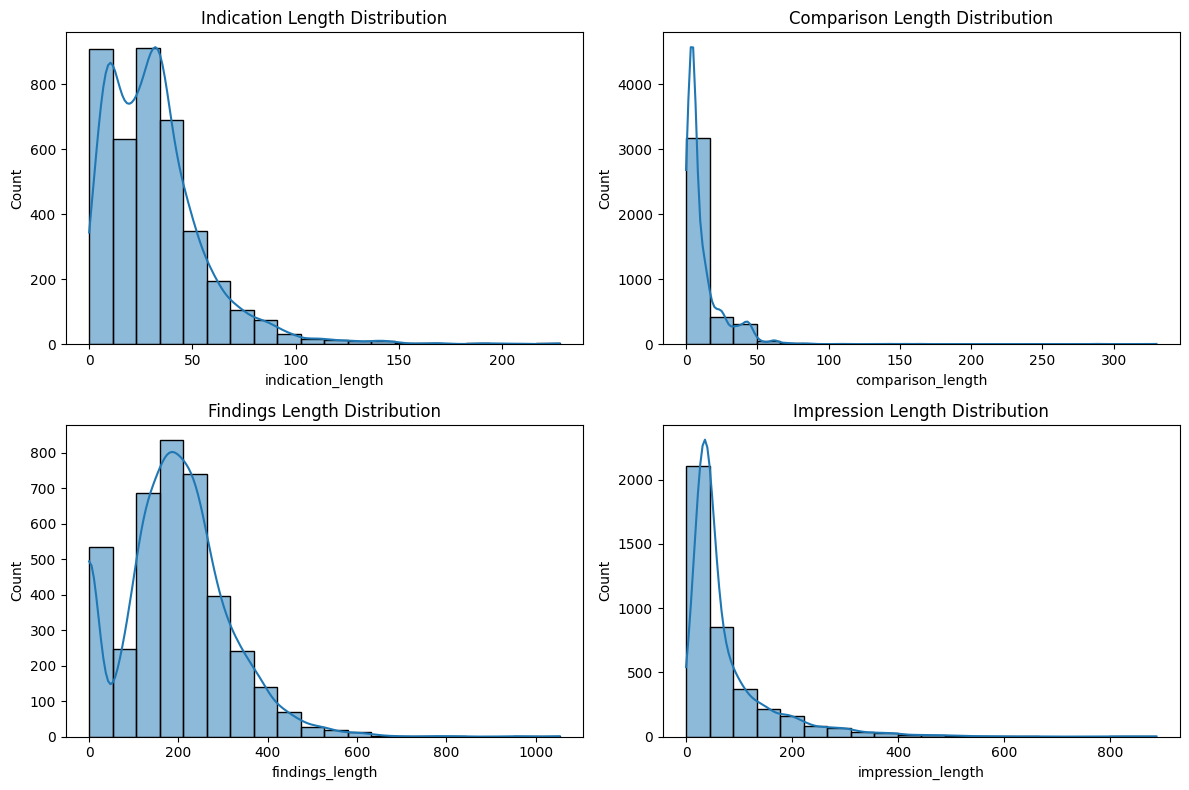

Word Cloud for Indications:


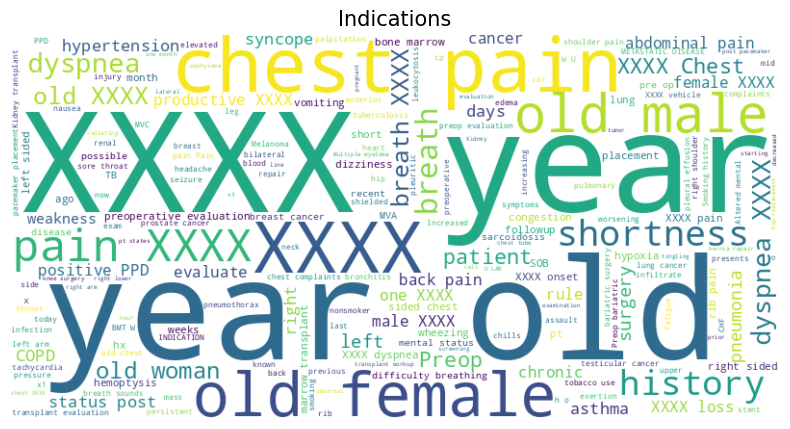

Word Cloud for Comparisons:


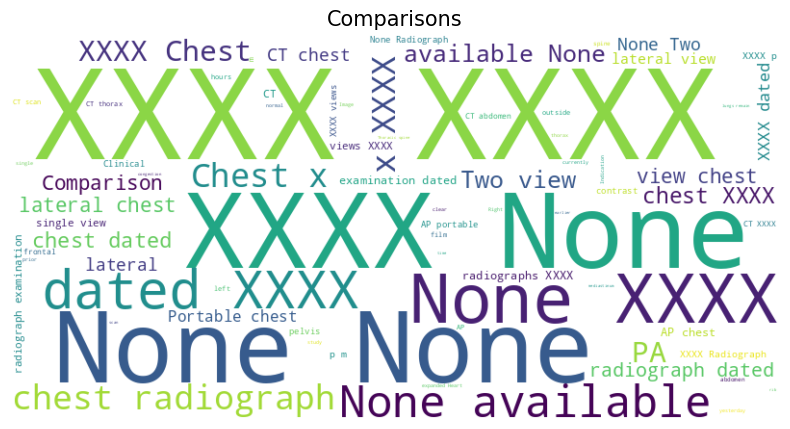

Word Cloud for Findings:


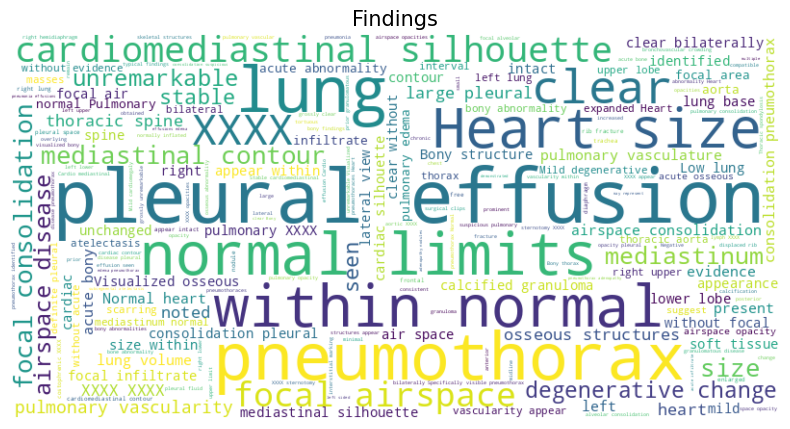

Word Cloud for Impressions:


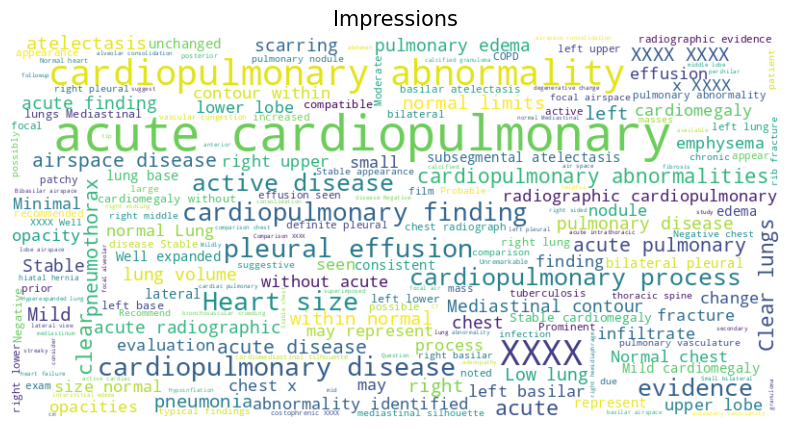


Most frequent words in Indications:
[('XXXX-year-old', 1383), ('XXXX', 1329), ('with', 1075), ('of', 657), ('chest', 617), ('pain', 599), ('XXXX.', 475), ('pain.', 451), ('and', 438), ('female', 362), ('Chest', 345), ('male', 295), ('for', 287), ('XXXX,', 252), ('shortness', 184), ('female,', 163), ('male,', 158), ('history', 152), ('breath.', 141), ('breath', 137)]

Most frequent words in Comparisons:
[('XXXX.', 879), ('XXXX', 849), ('None.', 838), ('None', 804), ('XXXX,', 689), ('chest', 440), ('Chest', 285), ('dated', 237), ('and', 196), ('radiograph', 175), ('PA', 155), ('lateral', 149), ('x-XXXX', 143), ('available.', 130), ('from', 113), ('the', 107), ('of', 100), ('views', 99), ('CT', 97), ('available', 91)]

Most frequent words in Findings:
[('is', 4420), ('are', 4385), ('The', 3568), ('No', 2971), ('and', 2831), ('the', 2824), ('pleural', 2468), ('of', 2457), ('or', 2407), ('There', 2346), ('XXXX', 2103), ('normal', 1976), ('focal', 1742), ('within', 1528), ('size', 1499), ('

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Create a DataFrame from the extracted data
data = pd.DataFrame({
    'png': png,
    'indication': indication,
    'comparison': comparison,
    'findings': findings,
    'impression': impression
})

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(data.head())

# Display basic statistics of the DataFrame
print("\nBasic statistics of the DataFrame:")
print(data.describe())

# Check for missing values
print("\nMissing values in the DataFrame:")
print(data.isnull().sum())

# Distribution of the lengths of the text in each column
data['indication_length'] = data['indication'].apply(len)
data['comparison_length'] = data['comparison'].apply(len)
data['findings_length'] = data['findings'].apply(len)
data['impression_length'] = data['impression'].apply(len)

# Plot histograms of the text lengths
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(data['indication_length'], bins=20, kde=True)
plt.title('Indication Length Distribution')

plt.subplot(2, 2, 2)
sns.histplot(data['comparison_length'], bins=20, kde=True)
plt.title('Comparison Length Distribution')

plt.subplot(2, 2, 3)
sns.histplot(data['findings_length'], bins=20, kde=True)
plt.title('Findings Length Distribution')

plt.subplot(2, 2, 4)
sns.histplot(data['impression_length'], bins=20, kde=True)
plt.title('Impression Length Distribution')

plt.tight_layout()
plt.show()

# Generate word clouds for each text column
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

print("Word Cloud for Indications:")
generate_wordcloud(data['indication'], 'Indications')

print("Word Cloud for Comparisons:")
generate_wordcloud(data['comparison'], 'Comparisons')

print("Word Cloud for Findings:")
generate_wordcloud(data['findings'], 'Findings')

print("Word Cloud for Impressions:")
generate_wordcloud(data['impression'], 'Impressions')

# Most frequent words in each column
from collections import Counter

def most_frequent_words(text, n=20):
    words = " ".join(text).split()
    counter = Counter(words)
    return counter.most_common(n)

print("\nMost frequent words in Indications:")
print(most_frequent_words(data['indication']))

print("\nMost frequent words in Comparisons:")
print(most_frequent_words(data['comparison']))

print("\nMost frequent words in Findings:")
print(most_frequent_words(data['findings']))

print("\nMost frequent words in Impressions:")
print(most_frequent_words(data['impression']))


Top 5 patients with the most images:
Patient ID: CXR1303, Number of Images: 5
Patient ID: CXR3359, Number of Images: 4
Patient ID: CXR3932, Number of Images: 4
Patient ID: CXR2280, Number of Images: 4
Patient ID: CXR3566, Number of Images: 4


/tmp/ipykernel_34/71486573.py:42: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(image_counts, bins=30, kde=True, palette=palette)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


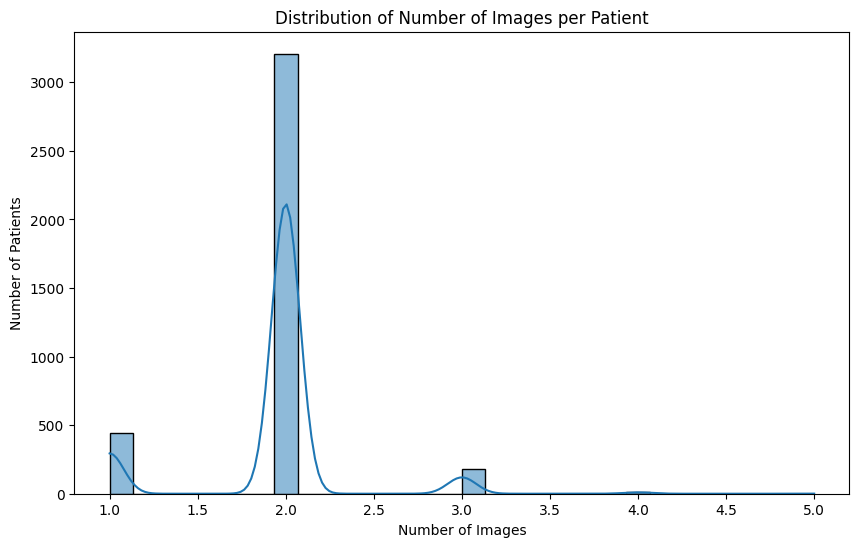

Total number of patients: 3851
Maximum number of images for a single patient: 5
Minimum number of images for a single patient: 1


In [5]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

## Directory where the images are stored
image_dir = '/kaggle/input/portfolio-project-carecloud22222/project/project'

## Initialize a dictionary to store the count of images per patient
patient_image_count = defaultdict(int)

## Iterate over all files in the image directory
for file in os.listdir(image_dir):
    if file.endswith('.png'):
        # Extract patient ID from the filename
        patient_id = file.split('_')[0]
        # Increment the count for this patient ID
        patient_image_count[patient_id] += 1

## Convert the dictionary to a list of tuples and sort by the number of images
sorted_patient_image_count = sorted(patient_image_count.items(), key=lambda x: x[1], reverse=True)

## Display the top 10 patients with the most images (or all patients if there are fewer than 10)
total_patients = len(patient_image_count)
if total_patients > 5:
    print("Top 5 patients with the most images:")
    for patient_id, count in sorted_patient_image_count[:5]:
        print(f"Patient ID: {patient_id}, Number of Images: {count}")
else:
    print("All patients with their number of images:")
    for patient_id, count in sorted_patient_image_count:
        print(f"Patient ID: {patient_id}, Number of Images: {count}")

## Plot the distribution of the number of images per patient
image_counts = list(patient_image_count.values())

### Adjust the figure size to fit the data
plt.figure(figsize=(10, 6))

### Use a bright color palette for the histogram bars
palette = sns.color_palette("bright", len(image_counts))
sns.histplot(image_counts, bins=30, kde=True, palette=palette)

plt.title('Distribution of Number of Images per Patient')
plt.xlabel('Number of Images')
plt.ylabel('Number of Patients')
plt.show()

## Print basic statistics
print(f"Total number of patients: {len(patient_image_count)}")
print(f"Maximum number of images for a single patient: {max(image_counts)}")
print(f"Minimum number of images for a single patient: {min(image_counts)}")

In [6]:
import pandas as pd
from collections import defaultdict
import os

# Directory where the images are stored
image_dir = '/kaggle/input/portfolio-project-carecloud22222/project/project'

# Initialize a dictionary to store the patient images
patient_images = defaultdict(list)

# Iterate over all files in the image directory
for file in os.listdir(image_dir):
    if file.endswith('.png'):
        # Extract patient ID from the filename
        patient_id = file.split('_')[0]
        # Append the file to the list of images for this patient ID
        patient_images[patient_id].append(file)

# Function to create data points based on the number of images
def create_data_points(images):
    data_points = []
    if len(images) == 1:
        # Single image: Duplicate the image
        data_points.append((images[0], images[0]))
    elif len(images) == 2:
        # Two images: Use both images
        data_points.append((images[0], images[1]))
    elif len(images) == 3:
        # Three images: Create two data points
        data_points.append((images[0], images[2]))
        data_points.append((images[1], images[2]))
    elif len(images) == 4:
        # Four images: Create two data points
        data_points.append((images[0], images[1]))
        data_points.append((images[2], images[3]))
    elif len(images) == 5:
        # Five images: Create three data points
        data_points.append((images[0], images[1]))
        data_points.append((images[2], images[3]))
        data_points.append((images[0], images[4]))
    return data_points

# Initialize a list to store the final data points
final_data_points = []

# Iterate over each patient and create data points
for patient_id, images in patient_images.items():
    # Sort images to maintain a consistent order
    images.sort()
    # Create data points for this patient
    data_points = create_data_points(images)
    # Add patient ID to each data point
    final_data_points.extend([(patient_id, dp[0], dp[1]) for dp in data_points])

# Create a DataFrame from the final data points
df = pd.DataFrame(final_data_points, columns=['patient_id', 'frontal', 'lateral'])

# Assuming `impression` data is available in some form, we'll add a placeholder for now
# Replace this with the actual extraction logic if impressions are already extracted
df['impression'] = df['patient_id'].apply(lambda x: "impression text for " + x)  # Placeholder example

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df.head())

# Basic statistics
print(f"Total number of data points: {len(df)}")
print(f"Total number of unique patients: {df['patient_id'].nunique()}")


First few rows of the DataFrame:
  patient_id                   frontal                   lateral  \
0    CXR1524  CXR1524_IM-0339-1001.png  CXR1524_IM-0339-2001.png   
1    CXR2661  CXR2661_IM-1142-1001.png  CXR2661_IM-1142-2001.png   
2    CXR1474  CXR1474_IM-0307-1001.png  CXR1474_IM-0307-2001.png   
3    CXR3130  CXR3130_IM-1472-1001.png  CXR3130_IM-1472-2001.png   
4     CXR764   CXR764_IM-2311-2001.png   CXR764_IM-2311-3001.png   

                    impression  
0  impression text for CXR1524  
1  impression text for CXR2661  
2  impression text for CXR1474  
3  impression text for CXR3130  
4   impression text for CXR764  
Total number of data points: 4049
Total number of unique patients: 3851


In [7]:
import os
import pandas as pd
import re
import xml.etree.ElementTree as ET
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict

# Define text preprocessing functions
def decontracted(phrase):
    if phrase is None:
        return ""
    phrase = phrase.lower()
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can't", "can not", phrase)
    phrase = re.sub(r"n't", " not", phrase)
    phrase = re.sub(r"'re", " are", phrase)
    phrase = re.sub(r"'s", " is", phrase)
    phrase = re.sub(r"'d", " would", phrase)
    phrase = re.sub(r"'ll", " will", phrase)
    phrase = re.sub(r"'t", " not", phrase)
    phrase = re.sub(r"'ve", " have", phrase)
    phrase = re.sub(r"'m", " am", phrase)
    return phrase

def text_preprocess(text):
    if text is None:
        return ""
    text = text.lower()
    text = re.sub("xxxx", "", text)
    text = re.sub("xxx", "", text)
    text = re.sub("-", "_", text)
    text = re.sub('&', ' and ', text)
    text = re.sub('@', ' at ', text)
    text = re.sub('0', ' zero ', text)
    text = re.sub('1', ' one ', text)
    text = re.sub('2', ' two ', text)
    text = re.sub('3', ' three ', text)
    text = re.sub('4', ' four ', text)
    text = re.sub('5', ' five ', text)
    text = re.sub('6', ' six ', text)
    text = re.sub('7', ' seven ', text)
    text = re.sub('8', ' eight ', text)
    text = re.sub('9', ' nine ', text)
    text = re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]", "", text)
    text = re.sub(r'\.\.+', '.', text)
    text = re.sub(r"\d", "", text)
    text = re.sub('year old', "", text)     
    text = re.sub('yearold', "", text)
    text = re.sub('[^a-z]+', ' ', text)
    return text

def remove_stop_words(text):
    if text is None:
        return ""
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    stop_words.remove('no')
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if w not in stop_words]
    return " ".join(filtered_sentence)

def less_two_remove(text):
    if text is None:
        return ""
    word_list = word_tokenize(text)
    need = ['tb', 'no', 'mm', 'ct']
    filtered_text = [i for i in word_list if len(i) > 2 or i in need]
    return " ".join(filtered_text)

def final_preprocess(text):
    text = decontracted(text)
    text = text_preprocess(text)
    text = remove_stop_words(text)
    text = less_two_remove(text)
    return text

# Directory paths
image_dir = '/kaggle/input/portfolio-project-carecloud22222/project/project'
report_dir = '/kaggle/input/portfolio-project-carecloud22222/project reports/project reports/ecgen-radiology'

# Function to parse the XML file and extract relevant sections
def parse_xml_report(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    patient_id = root.find('.//uId').attrib['id']
    comparison = root.find(".//AbstractText[@Label='COMPARISON']").text if root.find(".//AbstractText[@Label='COMPARISON']") is not None else ""
    indication = root.find(".//AbstractText[@Label='INDICATION']").text if root.find(".//AbstractText[@Label='INDICATION']") is not None else ""
    findings = root.find(".//AbstractText[@Label='FINDINGS']").text if root.find(".//AbstractText[@Label='FINDINGS']") is not None else ""
    impression = root.find(".//AbstractText[@Label='IMPRESSION']").text if root.find(".//AbstractText[@Label='IMPRESSION']") is not None else ""

    return {'patient_id': patient_id, 'comparison': comparison, 'indication': indication, 'findings': findings, 'impression': impression}

# Load reports
reports = []
for file in os.listdir(report_dir):
    if file.endswith('.xml'):
        file_path = os.path.join(report_dir, file)
        report = parse_xml_report(file_path)
        reports.append(report)

# Create a DataFrame from the reports
reports_df = pd.DataFrame(reports)

# Preprocess the reports
reports_df['indication'] = reports_df['indication'].apply(final_preprocess)
reports_df['comparison'] = reports_df['comparison'].apply(final_preprocess)
reports_df['findings'] = reports_df['findings'].apply(final_preprocess)
reports_df['impression'] = reports_df['impression'].apply(final_preprocess)

# Initialize a dictionary to store the patient images
patient_images = defaultdict(list)

# Iterate over all files in the image directory
for file in os.listdir(image_dir):
    if file.endswith('.png'):
        # Extract patient ID from the filename
        patient_id = file.split('_')[0]
        # Append the file to the list of images for this patient ID
        patient_images[patient_id].append(file)

# Function to create data points based on the number of images
def create_data_points(images):
    data_points = []
    if len(images) == 1:
        data_points.append((images[0], images[0]))
    elif len(images) == 2:
        data_points.append((images[0], images[1]))
    elif len(images) == 3:
        data_points.append((images[0], images[2]))
        data_points.append((images[1], images[2]))
    elif len(images) == 4:
        data_points.append((images[0], images[1]))
        data_points.append((images[2], images[3]))
    elif len(images) == 5:
        data_points.append((images[0], images[1]))
        data_points.append((images[2], images[3]))
        data_points.append((images[0], images[4]))
    return data_points

# Create a new DataFrame to store the final image data points
final_data_points = []

# Iterate over each patient and create data points
for patient_id, images in patient_images.items():
    images.sort()
    data_points = create_data_points(images)
    final_data_points.extend([(patient_id, dp[0], dp[1]) for dp in data_points])

# Create a DataFrame from the final data points
image_data = pd.DataFrame(final_data_points, columns=['patient_id', 'frontal', 'lateral'])

# Merge the image data with the report data
df = pd.merge(image_data, reports_df, on='patient_id', how='left')

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df.head())

# Basic statistics
print(f"Total number of data points: {len(df)}")
print(f"Total number of unique patients: {df['patient_id'].nunique()}")

# Optional: Save the DataFrame to a CSV file for later use
df.to_csv('/kaggle/working/final_imagedata.csv', index=False)
df

/tmp/ipykernel_34/2564365641.py:45: FutureWarning: Possible set union at position 4
  text = re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]", "", text)
/tmp/ipykernel_34/2564365641.py:45: FutureWarning: Possible set union at position 8
  text = re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]", "", text)
/tmp/ipykernel_34/2564365641.py:45: FutureWarning: Possible set union at position 21
  text = re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]", "", text)


First few rows of the DataFrame:
  patient_id                   frontal                   lateral comparison  \
0    CXR1524  CXR1524_IM-0339-1001.png  CXR1524_IM-0339-2001.png       none   
1    CXR2661  CXR2661_IM-1142-1001.png  CXR2661_IM-1142-2001.png       none   
2    CXR1474  CXR1474_IM-0307-1001.png  CXR1474_IM-0307-2001.png       none   
3    CXR3130  CXR3130_IM-1472-1001.png  CXR3130_IM-1472-2001.png              
4     CXR764   CXR764_IM-2311-2001.png   CXR764_IM-2311-3001.png       none   

                                   indication  \
0     preop right knee total knee replacement   
1                  year old female chest pain   
2                  year old female chest pain   
3                  shortness breath two weeks   
4  year old male abnormal feeling cocaine use   

                                            findings  \
0  heart size normal aorta tortuous not exclude a...   
1  mild cardiomegaly low lung volumes without foc...   
2  no pneumothorax heart size

patient_id                   frontal                   lateral  \
0       CXR1524  CXR1524_IM-0339-1001.png  CXR1524_IM-0339-2001.png   
1       CXR2661  CXR2661_IM-1142-1001.png  CXR2661_IM-1142-2001.png   
2       CXR1474  CXR1474_IM-0307-1001.png  CXR1474_IM-0307-2001.png   
3       CXR3130  CXR3130_IM-1472-1001.png  CXR3130_IM-1472-2001.png   
4        CXR764   CXR764_IM-2311-2001.png   CXR764_IM-2311-3001.png   
...         ...                       ...                       ...   
4044    CXR3567  CXR3567_IM-1752-1001.png  CXR3567_IM-1752-1001.png   
4045    CXR1398  CXR1398_IM-0254-1001.png  CXR1398_IM-0254-1001.png   
4046    CXR2937  CXR2937_IM-1339-1001.png  CXR2937_IM-1339-2001.png   
4047    CXR3278  CXR3278_IM-1559-0001.png  CXR3278_IM-1559-0001.png   
4048    CXR3056  CXR3056_IM-1423-2001.png  CXR3056_IM-1423-2001.png   

                     comparison  \
0                          none   
1                          none   
2                          none   
3                                 
4                          none   
...                         ...   
4044                              
4045                       none   
4046                              
4047             chest clinical   
4048  lateral chest radiographs   

                                             indication  \
0               preop right knee total knee replacement   
1                            year old female chest pain   
2                            year old female chest pain   
3                            shortness breath two weeks   
4            year old male abnormal feeling cocaine use   
...                                                 ...   
4044                 status post pacemaker implantation   
4045                          year old woman chest pain   
4046                     year old male complaining pain   
4047  mva back pain right clavicle numbness tingling...   
4048                            year old woman vomiting   

                                               findings  \
0     heart size normal aorta tortuous not exclude a...   
1     mild cardiomegaly low lung volumes without foc...   
2     no pneumothorax heart size normal granulomas s...   
3     two images heart size enlarged stable thoracic...   
4     cardiomediastinal silhouette normal size conto...   
...                                                 ...   
4044  lateral chest examination obtained heart silho...   
4045  lungs clear bilaterally specifically no eviden...   
4046  heart size mediastinal contours appear within ...   
4047  chest two images heart size normal mediastinal...   
4048  moderate layering right pleural effusion air f...   

                                             impression  
0     one no acute cardiopulmonary process two tortu...  
1               mild cardiomegaly without heart failure  
2                no acute cardiopulmonary abnormalities  
3     left lower lobe right perihilar airspace disea...  
4                                              negative  
...                                                 ...  
4044  one right lower lobe airspace disease small ef...  
4045               no acute cardiopulmonary abnormality  
4046                  no acute cardiopulmonary findings  
4047  chest one no acute cardiopulmonary abnormality...  
4048  airspace disease within superior segment right...  

[4049 rows x 7 columns]

In [8]:
df.isnull().sum()

patient_id    0
frontal       0
lateral       0
comparison    0
indication    0
findings      0
impression    0
dtype: int64

In [9]:
df = df.drop(['patient_id', 'comparison','indication','findings'], axis=1)

In [10]:
df.head()

frontal                   lateral  \
0  CXR1524_IM-0339-1001.png  CXR1524_IM-0339-2001.png   
1  CXR2661_IM-1142-1001.png  CXR2661_IM-1142-2001.png   
2  CXR1474_IM-0307-1001.png  CXR1474_IM-0307-2001.png   
3  CXR3130_IM-1472-1001.png  CXR3130_IM-1472-2001.png   
4   CXR764_IM-2311-2001.png   CXR764_IM-2311-3001.png   

                                          impression  
0  one no acute cardiopulmonary process two tortu...  
1            mild cardiomegaly without heart failure  
2             no acute cardiopulmonary abnormalities  
3  left lower lobe right perihilar airspace disea...  
4                                           negative

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Input, Dense, Conv2D, concatenate, Dropout, LSTM, Embedding, Concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm 
import json
import pickle
import cv2
import nltk
from PIL import Image
from keras import Model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import DenseNet121
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
import time
import datetime
import io
import nltk.translate.bleu_score as bleu
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
nltk.download('punkt')

2024-07-18 04:37:56.866975: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 04:37:56.867080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 04:37:56.994584: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
df

frontal                   lateral  \
0     CXR1524_IM-0339-1001.png  CXR1524_IM-0339-2001.png   
1     CXR2661_IM-1142-1001.png  CXR2661_IM-1142-2001.png   
2     CXR1474_IM-0307-1001.png  CXR1474_IM-0307-2001.png   
3     CXR3130_IM-1472-1001.png  CXR3130_IM-1472-2001.png   
4      CXR764_IM-2311-2001.png   CXR764_IM-2311-3001.png   
...                        ...                       ...   
4044  CXR3567_IM-1752-1001.png  CXR3567_IM-1752-1001.png   
4045  CXR1398_IM-0254-1001.png  CXR1398_IM-0254-1001.png   
4046  CXR2937_IM-1339-1001.png  CXR2937_IM-1339-2001.png   
4047  CXR3278_IM-1559-0001.png  CXR3278_IM-1559-0001.png   
4048  CXR3056_IM-1423-2001.png  CXR3056_IM-1423-2001.png   

                                             impression  
0     one no acute cardiopulmonary process two tortu...  
1               mild cardiomegaly without heart failure  
2                no acute cardiopulmonary abnormalities  
3     left lower lobe right perihilar airspace disea...  
4                                              negative  
...                                                 ...  
4044  one right lower lobe airspace disease small ef...  
4045               no acute cardiopulmonary abnormality  
4046                  no acute cardiopulmonary findings  
4047  chest one no acute cardiopulmonary abnormality...  
4048  airspace disease within superior segment right...  

[4049 rows x 3 columns]

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.05, random_state=42)

train_data, validation_data = train_test_split(train_data, test_size=0.25, random_state=42)

train_data.to_csv('/kaggle/working/train.csv', index=False)
test_data.to_csv('/kaggle/working/test.csv', index=False)
validation_data.to_csv('/kaggle/working/validation.csv', index=False)


In [14]:
train = pd.read_csv('/kaggle/working/train.csv')
test = pd.read_csv('/kaggle/working/test.csv')
validation = pd.read_csv('/kaggle/working/validation.csv')

train = train.iloc[:, 0:]
test = test.iloc[:, 0:]
validation = validation.iloc[:, 0:]

print("train data -     ",train.shape)
print('test data -      ',test.shape)
print('validation data -',validation.shape)

train data -      (2884, 3)
test data -       (203, 3)
validation data - (962, 3)


In [15]:
train.impression      = '<start> ' + train.impression + ' <end>'
validation.impression = '<start> ' + validation.impression + ' <end>'
test.impression       = '<start> ' + test.impression + ' <end>'

In [16]:
test.head()

frontal                   lateral  \
0  CXR1101_IM-0068-2001.png  CXR1101_IM-0068-3001.png   
1  CXR2159_IM-0776-1001.png  CXR2159_IM-0776-2001.png   
2  CXR2063_IM-0700-1001.png  CXR2063_IM-0700-2001.png   
3  CXR3971_IM-2031-1001.png  CXR3971_IM-2031-3001.png   
4  CXR1133_IM-0090-1001.png  CXR1133_IM-0090-1002.png   

                                          impression  
0     <start> no acute cardiopulmonary disease <end>  
1   <start> one no acute pulmonary abnormality <end>  
2  <start> heart size normal bilateral nipple sha...  
3     <start> no acute cardiopulmonary finding <end>  
4       <start> findings copd no acute changes <end>

In [17]:
train.head()

frontal                   lateral  \
0  CXR1750_IM-0493-1001.png  CXR1750_IM-0493-2001.png   
1  CXR1915_IM-0595-1001.png  CXR1915_IM-0595-1002.png   
2  CXR2870_IM-1276-1001.png  CXR2870_IM-1276-2001.png   
3  CXR2478_IM-1007-1001.png  CXR2478_IM-1007-2001.png   
4  CXR1330_IM-0213-1001.png  CXR1330_IM-0213-2001.png   

                                          impression  
0  <start> one no acute cardiopulmonary findings ...  
1                    <start> no active disease <end>  
2  <start> no acute cardiopulmonary abnormality i...  
3  <start> copd interstitial lung disease no defi...  
4  <start> negative acute cardiopulmonary finding...

In [18]:
validation.head()

frontal                        lateral  \
0       CXR2594_IM-1085-1001.png       CXR2594_IM-1085-3001.png   
1        CXR132_IM-0206-1001.png        CXR132_IM-0206-1001.png   
2       CXR3317_IM-1587-1001.png       CXR3317_IM-1587-2001.png   
3       CXR2145_IM-0766-2001.png       CXR2145_IM-0766-3001.png   
4  CXR1527_IM-0341-1001-0002.png  CXR1527_IM-0341-1001-0002.png   

                                          impression  
0  <start> streaky right lower lobe infiltrate ve...  
1  <start> no acute cardiopulmonary abnormality <...  
2     <start> no acute cardiopulmonary disease <end>  
3                         <start> normal chest <end>  
4  <start> one emphysematous change without acute...

In [19]:
  
model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')
input_layer  = model.input
output_layer = model.layers[-1].output

image_model = tf.keras.Model(input_layer, output_layer)
image_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      9,216 │ activation[0][0]  │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     18,432 │ activation_1[0][… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │      5,120 │ max_pooling2d[0]… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │    138,240 │ activation_3[0][… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, None,      │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [20]:
input_layer, output_layer

(<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=None, name=keras_tensor>,
 <KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=keras_tensor_311>)

In [21]:
image_1 = Input(shape=(256,256,3),name="image_1_features")
image_2 = Input(shape=(256,256,3),name="image_2_features")

# call the inception v3 model
image_1_out = image_model(image_1)
image_2_out = image_model(image_2)

merge = concatenate((image_1_out,image_2_out),axis=-1,name="final_image_features")
model = Model(inputs=[image_1,image_2],outputs= merge)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_1_features    │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_2_features    │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 2048)      │ 21,802,784 │ image_1_features… │
│ (Functional)        │                   │            │ image_2_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_image_featur… │ (None, 4096)      │          0 │ functional[0][0], │
│ (Concatenate)       │                   │            │ functional[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [22]:
def preprocess(image_path1, image_path2, path):
    '''
    input -- image 1 , image 2, image's path
    output -- image tensor
    process - convert two images into 256 X 256, then using inception model generate tensor (concate two image tensor)


    '''

    # join path and image name 
    image_path1 = path + image_path1
    image_path2 = path + image_path2
    
    # load the images
    img1 = image.load_img(image_path1, target_size=(256,256))
    img2 = image.load_img(image_path2, target_size=(256,256))

    # Convert PIL image to numpy array of 3-dimensions
    x1 = image.img_to_array(img1)
    x2 = image.img_to_array(img2)

    # Add one more dimension
    x1 = np.expand_dims(x1, axis=0)
    x2 = np.expand_dims(x2, axis=0)

    # preprocess the images using preprocess_input() from inception module
    x1 = preprocess_input(x1)
    x2 = preprocess_input(x2)
    
    # create tensor
    tensor = model([x1,x2])
    
    return tensor

In [23]:
path = '/kaggle/input/portfolio-project-carecloud22222/project/project/'

# train data
image_train = [ ]
for col in tqdm(train.values):
    tensor = preprocess(col[0], col[1], path)
    image_train.append(tensor)

# validation data
image_validation = [ ]
for col in tqdm(validation.values):
    tensor = preprocess(col[0], col[1], path)
    image_validation.append(tensor)

print(f'shape of the train and validation image list are {len(image_train)} and  {len(image_validation)}')
print(f'shape of the train and validation image tensor are {image_train[0].shape} and  {image_validation[0].shape}')

  0%|          | 0/2884 [00:00<?, ?it/s]

  0%|          | 0/962 [00:00<?, ?it/s]

shape of the train and validation image list are 2884 and  962
shape of the train and validation image tensor are (1, 4096) and  (1, 4096)


In [24]:
for i in [image_train, image_validation]:
    print(len(i))

2884
962


In [25]:
np.save("/kaggle/working/train_image_features_3", image_train)
np.save("/kaggle/working/validation_image_features_3",  image_validation) 

In [26]:
image_train = np.load('/kaggle/working/train_image_features_3.npy')
image_validation = np.load('/kaggle/working/validation_image_features_3.npy')

In [27]:
train.head()

frontal                   lateral  \
0  CXR1750_IM-0493-1001.png  CXR1750_IM-0493-2001.png   
1  CXR1915_IM-0595-1001.png  CXR1915_IM-0595-1002.png   
2  CXR2870_IM-1276-1001.png  CXR2870_IM-1276-2001.png   
3  CXR2478_IM-1007-1001.png  CXR2478_IM-1007-2001.png   
4  CXR1330_IM-0213-1001.png  CXR1330_IM-0213-2001.png   

                                          impression  
0  <start> one no acute cardiopulmonary findings ...  
1                    <start> no active disease <end>  
2  <start> no acute cardiopulmonary abnormality i...  
3  <start> copd interstitial lung disease no defi...  
4  <start> negative acute cardiopulmonary finding...

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure all entries are strings and fill NaNs with empty strings
train['impression'] = train['impression'].fillna('').astype(str)
validation['impression'] = validation['impression'].fillna('').astype(str)

# Initialize the tokenizer with the specified filters
token = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^`{|}~\t\n')

# Fit the tokenizer on the training data
token.fit_on_texts(train['impression'])

# Convert texts to sequences
token_train = token.texts_to_sequences(train['impression'])
token_val = token.texts_to_sequences(validation['impression'])

# Print the vocabulary size
print('Vocab size - ', len(token.word_index))

# Define the maximum sequence length
max_len = 60

# Pad sequences to ensure uniform length
pad_train = pad_sequences(token_train, maxlen=max_len, dtype='int32', padding='post', truncating='post')
pad_val = pad_sequences(token_val, maxlen=max_len, dtype='int32', padding='post', truncating='post')

# Print a sample padded sequence
print(pad_train[:1])

# Create word index and reverse index mappings
word_idx = {k: v for k, v in token.word_index.items()}
idx_word = {v: k for k, v in token.word_index.items()}

# Calculate vocabulary size
vocab_size = len(word_idx) + 1


Vocab size -  1265
[[ 1  7  3  4  5 13 14 65 49 75 11 53 57  2  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0]]


In [29]:
list_sents = [ ]
for sent_tok in train.impression :
    for sent in nltk.sent_tokenize(sent_tok) :
        # replace start and end token, otherwise list_sent got like  <, start ,> 

        sent = sent.replace('<start>', "")
        sent = sent.replace('<end>', "")

        list_sents.append(['<start>' , *nltk.word_tokenize(sent) , '<end>'])
        

w2v = Word2Vec(sentences= list_sents, vector_size=300, window=5, min_count=1, workers=4)

In [30]:
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tqdm(token.word_index.items()):
    
    embedding_vector = w2v.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

  0%|          | 0/1265 [00:00<?, ?it/s]

In [31]:
embedding_matrix.shape

(1266, 300)

In [32]:
batch_size = 20

train_dataset = tf.data.Dataset.from_tensor_slices((image_train, pad_train))
train_dataset = train_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((image_validation, pad_val))
val_dataset = val_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [33]:
for i,j in train_dataset :
    print(i,j)
    break

tf.Tensor(
[[[0.33112258 0.3074933  0.13475034 ... 0.54885286 0.22464657 1.2735349 ]]

 [[0.4307567  0.9460261  0.30059576 ... 0.28791383 0.09813191 1.0000318 ]]

 [[0.41206548 1.0264459  0.2572637  ... 0.26759744 0.27790686 1.721156  ]]

 ...

 [[0.5065592  0.67149067 0.04526101 ... 0.18045717 0.2544936  0.90755695]]

 [[0.4191851  1.4114428  0.89082646 ... 0.51652545 0.30968857 0.99857265]]

 [[0.66533375 0.5202806  0.2595452  ... 0.25335872 0.05649127 0.45187357]]], shape=(20, 1, 4096), dtype=float32) tf.Tensor(
[[ 1 22 23 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 1 22 23 ...  0  0  0]
 ...
 [ 1  7  3 ...  0  0  0]
 [ 1 48  4 ...  0  0  0]
 [ 1  3  4 ...  0  0  0]], shape=(20, 60), dtype=int32)


In [34]:
for i,j in val_dataset :
    print(i,j)
    break

tf.Tensor(
[[[0.49958605 1.0250609  0.27161095 ... 0.2520593  0.37585178 1.533826  ]]

 [[0.8469659  0.48020378 0.20953502 ... 0.13503908 0.3488874  1.849713  ]]

 [[0.531578   0.8604204  0.46626744 ... 0.5134008  0.         0.9202532 ]]

 ...

 [[0.23542207 0.35466406 0.4106349  ... 0.28446293 0.00421765 0.99351954]]

 [[0.31451946 0.21071422 0.15689836 ... 0.22135228 0.08558836 1.2388552 ]]

 [[0.20240295 0.5399403  0.25944954 ... 0.4031894  0.12892132 0.26609796]]], shape=(20, 1, 4096), dtype=float32) tf.Tensor(
[[  1   3   4 ...   0   0   0]
 [  1 166 165 ...   0   0   0]
 [  1   3   4 ...   0   0   0]
 ...
 [  1 196  27 ...   0   0   0]
 [  1   3   4 ...   0   0   0]
 [  1 239  27 ...   0   0   0]], shape=(20, 60), dtype=int32)


In [35]:
input_layer = Input(shape=(1,4096), name = 'Image input')
encoder_out = Dense(300, name = 'image_dense')(input_layer)

input_layer_text = tf.keras.layers.Input(shape=(1,), name = 'text inout')
x = Embedding(input_dim = vocab_size, output_dim=300, input_length=max_len, mask_zero=True, trainable=False, weights=[embedding_matrix])(input_layer_text)
x = Concatenate()([x, encoder_out])
x = LSTM(512, return_sequences= True)(x)
x = Dense(vocab_size)(x)
model1 = Model([input_layer, input_layer_text],x)
model1.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text inout          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Image input         │ (None, 1, 4096)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 1)         │          0 │ text inout[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dense (Dense) │ (None, 1, 300)    │  1,229,100 │ Image input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dims         │ (None, 1, 1)      │          0 │ not_equal[0][0]   │
│ (ExpandDims)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ broadcast_to        │ (None, 1, 300)    │          0 │ expand_dims[0][0] │
│ (BroadcastTo)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ones_like           │ (None, 1, 300)    │          0 │ image_dense[0][0] │
│ (OnesLike)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 300)    │    379,800 │ text inout[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1, 600)    │          0 │ broadcast_to[0][… │
│ (Concatenate)       │                   │            │ ones_like[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1, 600)    │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ image_dense[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 1)         │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1, 512)    │  2,279,424 │ concatenate_2[0]… │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1266)   │    649,458 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,537,782 (17.31 MB)

 Trainable params: 4,157,982 (15.86 MB)

 Non-trainable params: 379,800 (1.45 MB)

In [36]:
 class Encoder(tf.keras.Model) :
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.dense = Dense(units= self.embedding_dim, kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 40), name = 'encoder_dense_layer')
    
    def call(self, x):
        
        x = self.dense(x)
        x = tf.nn.relu(x)

        return x

In [37]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, lstm_units, vocab_size):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.lstm_units = lstm_units

        self.embedding = Embedding(self.vocab_size, self.embedding_dim, mask_zero=True, trainable=False, weights=[embedding_matrix], name = 'Decoder_embedding')
        self.lstm     = LSTM(self.lstm_units, return_sequences= True, 
                             return_state= True, 
                             kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 40),
                             name = 'decoder_lstm')
        
        self.dense    = Dense(self.vocab_size, name = 'Decoder_dense')

        
    def call(self, x, image_features) :

        x = self.embedding(x)
        x = tf.concat([x, image_features], axis=-1)
        output, state, _ = self.lstm(x)
        x = self.dense(output)

        return x

In [38]:
# https://www.tensorflow.org/tutorials/text/image_captioning

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
acc_obj = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def loss_func(real, pred):
    # Ensure real (target) matches the shape expected by sparse categorical cross-entropy
    real = tf.reshape(real, [-1])  # Flatten to (batch_size * sequence_length,)
    
    # Flatten predictions to match target shape
    pred = tf.reshape(pred, [-1, pred.shape[-1]])  # Flatten to (batch_size * sequence_length, num_classes)
    
    # Calculate sparse categorical cross-entropy loss
    loss_ = loss_object(real, pred)
    
    return tf.reduce_mean(loss_)


  
def acc_func(real, pred):
    acc_f = acc_obj(real, pred)
    return tf.reduce_mean(acc_f)

In [39]:
embedding_dim = 300
encoder = Encoder(embedding_dim = embedding_dim)

lstm_units = 600
decoder = Decoder(embedding_dim = embedding_dim, lstm_units = lstm_units , vocab_size = vocab_size)

In [40]:
@tf.function
def train_step(tensor, target):

    loss = 0
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)
    train_acc = 0  # Initialize train_acc before using it

    with tf.GradientTape() as tape:
        features = encoder(tensor)

        for i in range(1, target.shape[1]):         
            predictions = decoder(dec_input, features)
            loss += loss_func(target[:, i], predictions)
            train_acc += acc_func(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
       
    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss
###################################################################################

@tf.function
def val_step(tensor, target):

    loss_val = 0
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)
    test_acc = 0  # Initialize test_acc before using it

    with tf.GradientTape() as tape:
        features = encoder(tensor)

        for i in range(1, target.shape[1]):
            predictions_val = decoder(dec_input, features)
            loss_val += loss_func(target[:, i], predictions_val)
            test_acc += acc_func(target[:, i], predictions_val)
            dec_input = tf.expand_dims(target[:, i], 1)
        
    total_loss_val = (loss_val / int(target.shape[1]))

    return loss_val, total_loss_val


Epoch 1 Train Loss: 0.955119   Validation Loss: 0.889283
Time taken for epoch 1: 44.84 sec

Epoch 2 Train Loss: 0.894631   Validation Loss: 0.872311
Time taken for epoch 2: 20.71 sec

Epoch 3 Train Loss: 0.872265   Validation Loss: 0.841110
Time taken for epoch 3: 20.71 sec

Epoch 4 Train Loss: 0.857229   Validation Loss: 0.814771
Time taken for epoch 4: 20.68 sec

Epoch 5 Train Loss: 0.818730   Validation Loss: 0.784134
Time taken for epoch 5: 20.68 sec

Epoch 6 Train Loss: 0.782639   Validation Loss: 0.769917
Time taken for epoch 6: 20.73 sec

Epoch 7 Train Loss: 0.744112   Validation Loss: 0.702068
Time taken for epoch 7: 20.68 sec

Epoch 8 Train Loss: 0.708565   Validation Loss: 0.684594
Time taken for epoch 8: 20.68 sec

Epoch 9 Train Loss: 0.675287   Validation Loss: 0.658979
Time taken for epoch 9: 20.72 sec

Epoch 10 Train Loss: 0.652288   Validation Loss: 0.639516
Time taken for epoch 10: 20.69 sec

Epoch 11 Train Loss: 0.632031   Validation Loss: 0.645787
Time taken for epoch

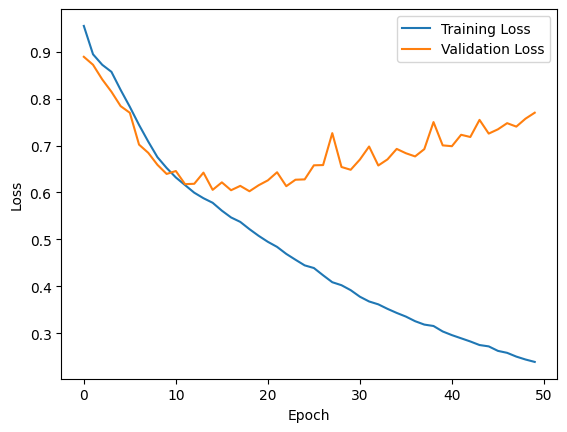

In [42]:
import time
import tensorflow as tf
import matplotlib.pyplot as plt

# Clear any previous session to start fresh
tf.keras.backend.clear_session()

# Define the number of epochs and initialize lists to store losses
EPOCHS = 50
loss_plot_train = []
loss_plot_val = []

# Iterate over epochs
for epoch in range(EPOCHS):
    start = time.time()
    total_loss_train = 0
    total_loss_val = 0

    # Training loop
    num_train_steps = 0
    for batch, (img_tensor, target) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss_train += t_loss.numpy()  # Ensure to convert TensorFlow tensor to numpy for accumulation
        num_train_steps += 1

    # Calculate average training loss for the epoch
    avg_train_loss = total_loss_train / num_train_steps
    loss_plot_train.append(avg_train_loss)

    # Validation loop
    num_val_steps = 0
    for batch, (img_tensor, target) in enumerate(val_dataset):
        batch_loss, t_loss = val_step(img_tensor, target)
        total_loss_val += t_loss.numpy()  # Ensure to convert TensorFlow tensor to numpy for accumulation
        num_val_steps += 1

    # Calculate average validation loss for the epoch
    avg_val_loss = total_loss_val / num_val_steps
    loss_plot_val.append(avg_val_loss)

    # Print epoch results
    print(f'Epoch {epoch + 1} Train Loss: {avg_train_loss:.6f}   Validation Loss: {avg_val_loss:.6f}')
    print(f'Time taken for epoch {epoch + 1}: {time.time() - start:.2f} sec\n')

# Plot the training and validation loss curves
plt.plot(loss_plot_train, label='Training Loss')
plt.plot(loss_plot_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [49]:
def save_model(model, filename):
    model.save(f'/kaggle/working/model.h5')

# Function to save the encoder (assuming it's a separate model)
def save_encoder(encoder, filename):
    encoder.save(f'/kaggle/working/encoder.h5')

# Function to save the decoder (assuming it's a separate model)
def save_decoder(decoder, filename):
    decoder.save(f'/kaggle/working/decoder.h5')

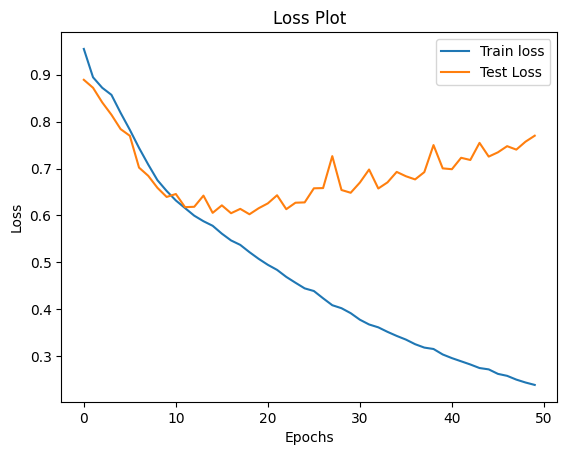

In [43]:
plt.plot(loss_plot_train, label = 'Train loss')
plt.plot(loss_plot_val, label = 'Test Loss')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

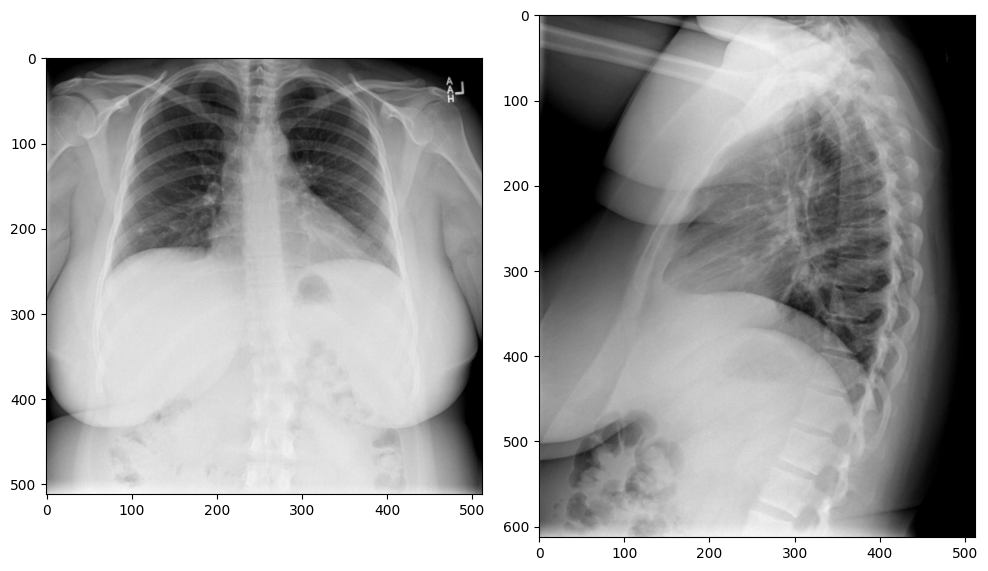

Actual : 
Predicted:  no acute cardiopulmonary abnormality <end>
BLEU Score :- N/A (Actual report not provided or not in correct format)


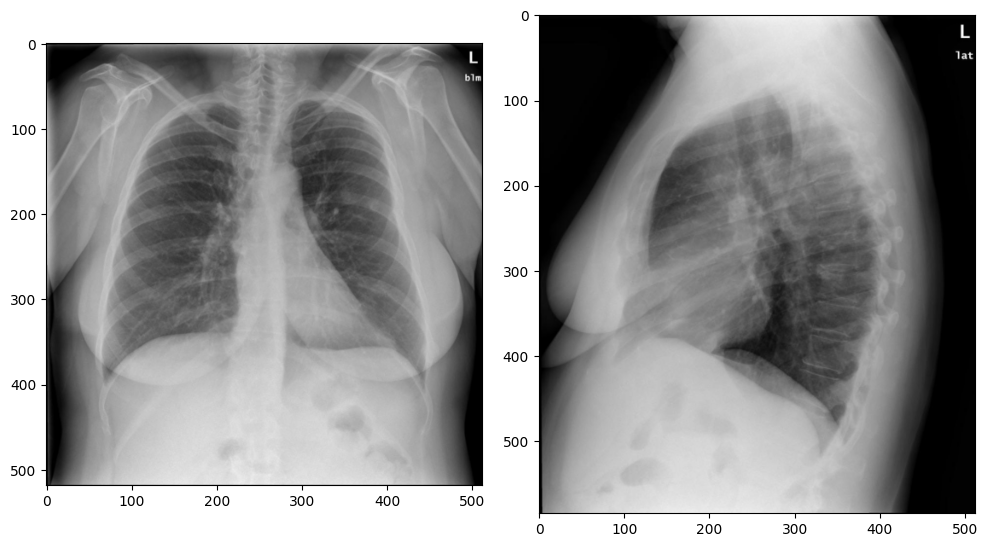

Actual : <start> no acute cardiopulmonary abnormality <end>
Predicted:  one no acute cardiopulmonary disease <end>
BLEU Score :- 0.5081327481546147


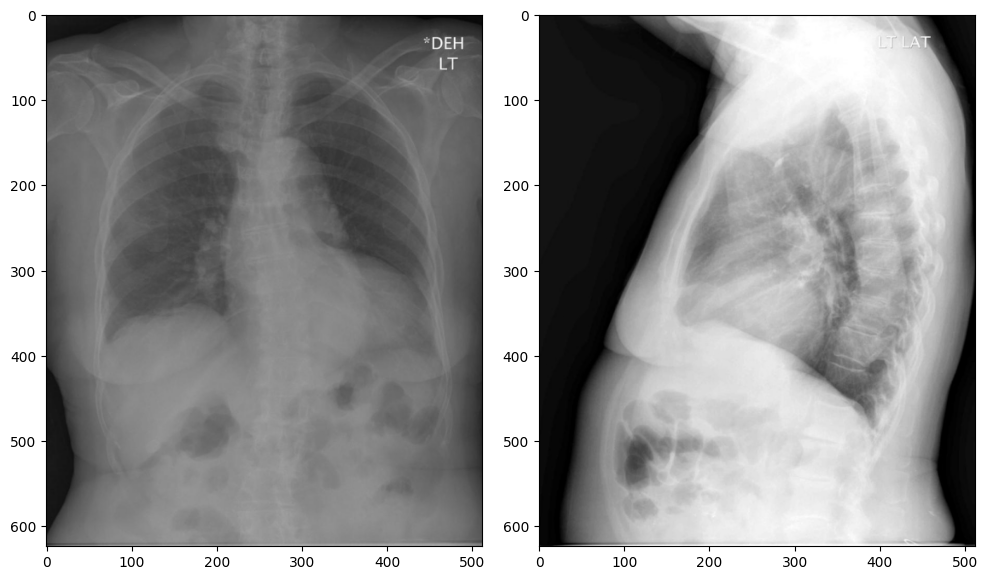

Actual : <start> chronic changes without acute process <end>
Predicted:  one no acute process <end>
BLEU Score :- 0.3769486629893372


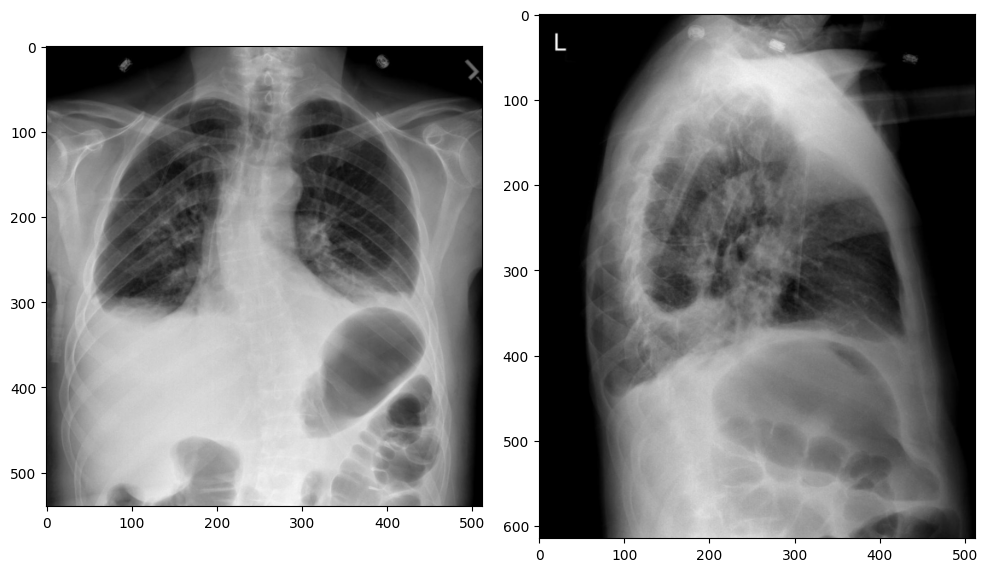

Actual : <start> borderline heart size aortic atherosclerosis small volume effusions basilar airspace disease right sided central catheter tip low svc tube removed mild distention stomach <end>
Predicted:  no acute findings <end>
BLEU Score :- 0.0037105558444623338


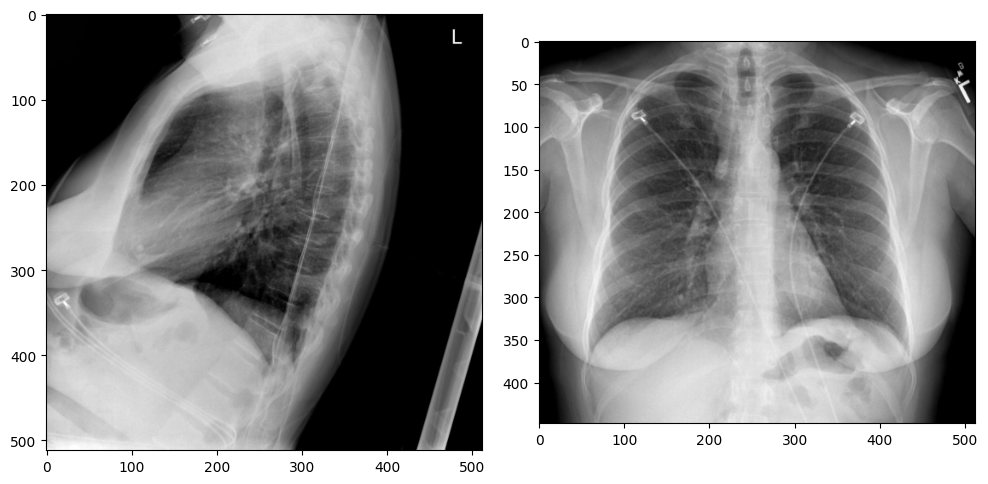

Actual : <start> no evidence acute cardiopulmonary process <end>
Predicted:  no acute cardiopulmonary abnormality <end>
BLEU Score :- 0.4482700320176827


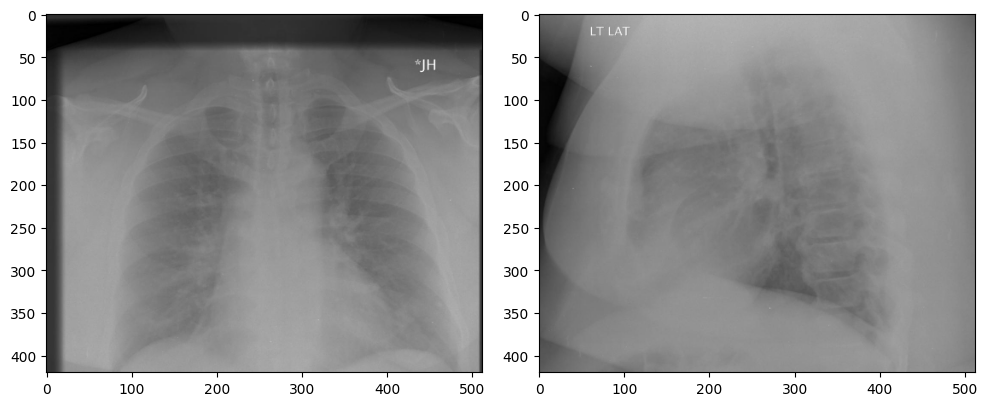

Actual : <start> one no acute pulmonary disease <end>
Predicted:  one no acute cardiopulmonary abnormality <end>
BLEU Score :- 0.43012508513132625


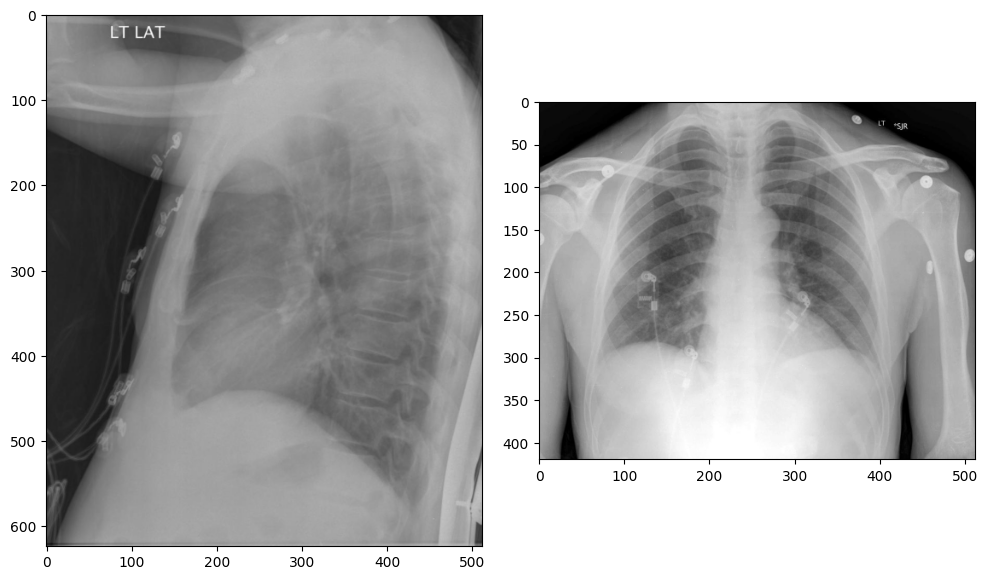

Actual : <start> negative acute cardiopulmonary abnormality <end>
Predicted:  no acute disease <end>
BLEU Score :- 0.510029457493824


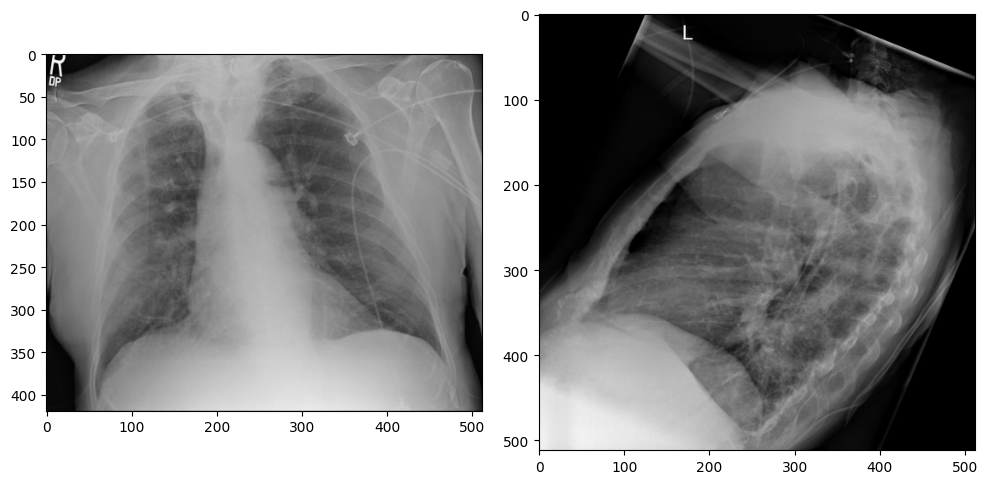

Actual : <start> stable silhouette no pneumothorax no focal consolidation no large pleural effusion unchanged pleural thickening visualized lung apices mild osteopenia degenerative changes no fractures <end>
Predicted:  <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
BLEU Score :- 0


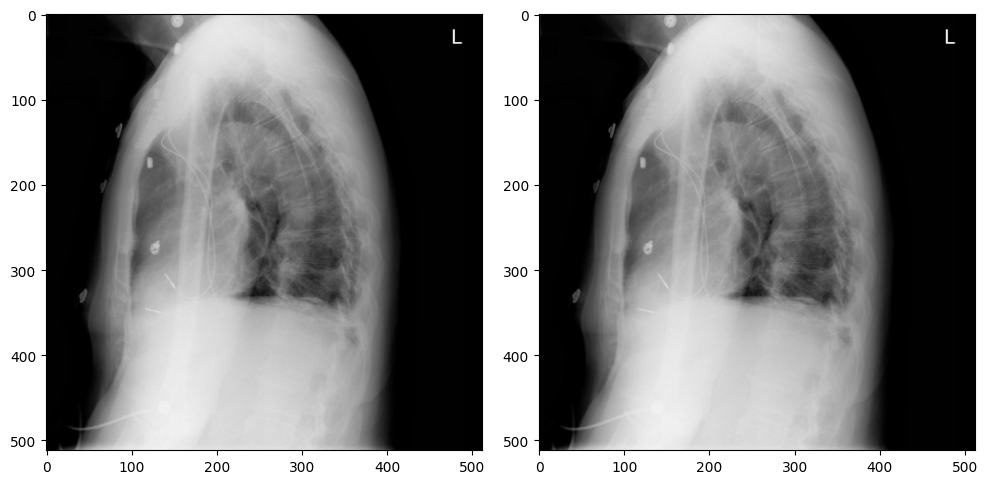

Actual : <start> one cardiac stable position two increase right decrease left basilar atelectasis <end>
Predicted:  one stable appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance appearance
BLEU Score :- 0.42728700639623407


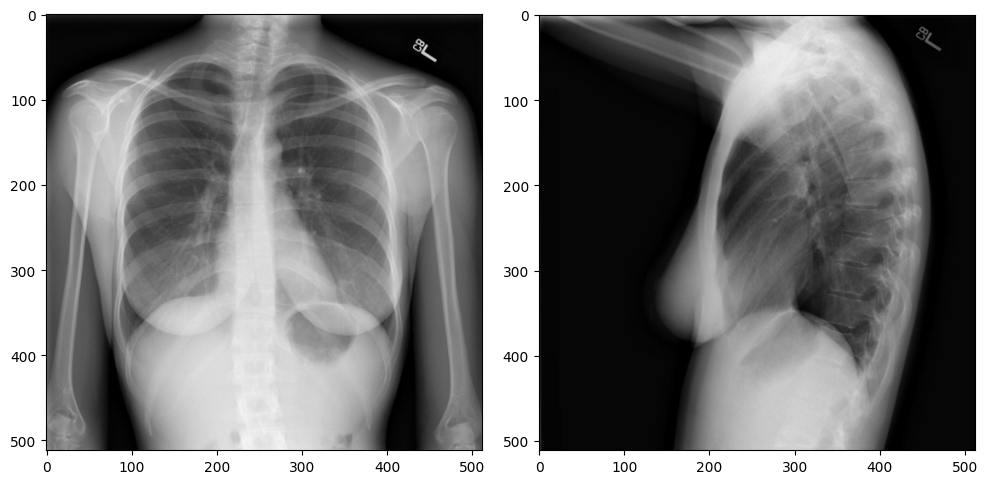

Actual : <start> heart size cardiomediastinal silhouette within normal limits pulmonary vasculature appears normal left hilar medial left base granuloma no focal air space consolidation no pleural effusion pneumothorax <end>
Predicted:  no acute cardiopulmonary findings <end>
BLEU Score :- 0.007993930738081441


In [46]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

# Adjust the evaluate function according to your previous code
def evaluate(image1, image2, path):
    '''
    Input - two images and image path
    Output - return medical report of the images
    This function takes images and using encoder-decoder model
    returns medical report of the images
    '''

    img_tensor_val = preprocess(image1, image2, path)

    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([token.word_index['<start>']], 1)
    features = tf.expand_dims(features, 0)
    text = ""
    max_len = 60
    for i in range(max_len):
        predictions = decoder(dec_input, features)
        predictions = tf.reshape(predictions, [predictions.shape[0], predictions.shape[2]])
        predicted_id = tf.argmax(predictions, axis=1)[0].numpy()
        if predicted_id in token.index_word:
            text += " " + token.index_word[predicted_id]
            if token.index_word[predicted_id] == '<end>':
                return text
        else:
            print(f'Warning: predicted_id {predicted_id} not found in token.index_word')
            text += " <unk>"  # Use <unk> for unknown tokens
        dec_input = tf.expand_dims([predicted_id], 1)
    return text

# Function to display images and their reports
def test_img_cap(img_data):
    '''
    Input - image data point containing two x-ray images and actual medical report of the images
    Output - function returns two images and their original and predicted medical report
    also returns BLEU score of the context
    '''
    path = "/kaggle/input/portfolio-project-carecloud22222/project/project/"
    result = evaluate(img_data[0], img_data[1], path=path)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 10), tight_layout=True)
    count = 0
    for img, subplot in zip(img_data[:2], axs.flatten()):
        img_ = mpimg.imread(path + img)
        axs[count].imshow(img_, cmap='bone')
        count += 1
    plt.show()

    actual_report = img_data[2] if isinstance(img_data[2], str) else ""
    print('Actual :', actual_report)
    print("Predicted:", result)
    if actual_report:
        print('BLEU Score :-', sentence_bleu([actual_report.split()], result.split()))
    else:
        print('BLEU Score :-', 'N/A (Actual report not provided or not in correct format)')

# Loop through a subset of the test dataset
for i in test.values[18:28]:
    test_img_cap(i)


# new model

100%|██████████| 1265/1265 [00:00<00:00, 206821.34it/s]
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'concatenate_layer_2' (of type ConcatenateLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1 Train Loss: 1.286184   Validation Loss: 0.979419
Time taken for epoch 1: 112.61 sec

Epoch 2 Train Loss: 0.933592   Validation Loss: 0.868862
Time taken for epoch 2: 24.72 sec

Epoch 3 Train Loss: 0.879564   Validation Loss: 0.842899
Time taken for epoch 3: 24.72 sec

Epoch 4 Train Loss: 0.848560   Validation Loss: 0.807568
Time taken for epoch 4: 24.71 sec

Epoch 5 Train Loss: 0.827247   Validation Loss: 0.782122
Time taken for epoch 5: 24.72 sec

Epoch 6 Train Loss: 0.806733   Validation Loss: 0.762625
Time taken for epoch 6: 24.70 sec

Epoch 7 Train Loss: 0.776428   Validation Loss: 0.766163
Time taken for epoch 7: 24.72 sec

Epoch 8 Train Loss: 0.754905   Validation Loss: 0.760217
Time taken for epoch 8: 24.71 sec

Epoch 9 Train Loss: 0.732118   Validation Loss: 0.723409
Time taken for epoch 9: 24.74 sec

Epoch 10 Train Loss: 0.707151   Validation Loss: 0.685527
Time taken for epoch 10: 24.70 sec

Epoch 11 Train Loss: 0.690675   Validation Loss: 0.691656
Time taken for epoc

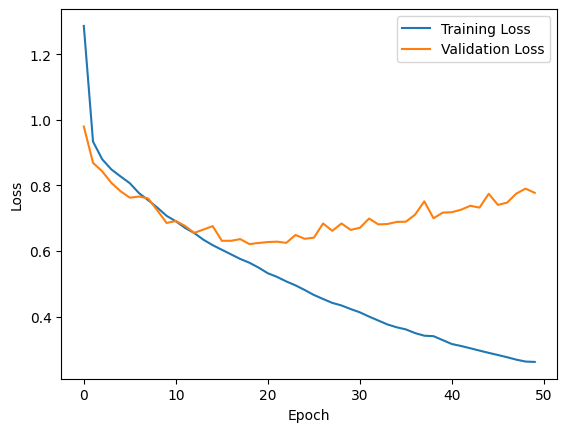

In [53]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import nltk
from gensim.models import Word2Vec
import time

# InceptionV3 model
model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')
input_layer = model.input
output_layer = model.layers[-1].output

image_model = tf.keras.Model(input_layer, output_layer)
image_1 = Input(shape=(256, 256, 3), name="image_1_features")
image_2 = Input(shape=(256, 256, 3), name="image_2_features")

image_1_out = image_model(image_1)
image_2_out = image_model(image_2)

merge = Concatenate(axis=-1, name="final_image_features")([image_1_out, image_2_out])
model = Model(inputs=[image_1, image_2], outputs=merge)

# Preprocess function
def preprocess(image_path1, image_path2, path):
    image_path1 = path + image_path1
    image_path2 = path + image_path2
    
    img1 = image.load_img(image_path1, target_size=(256,256))
    img2 = image.load_img(image_path2, target_size=(256,256))

    x1 = image.img_to_array(img1)
    x2 = image.img_to_array(img2)

    x1 = np.expand_dims(x1, axis=0)
    x2 = np.expand_dims(x2, axis=0)

    x1 = preprocess_input(x1)
    x2 = preprocess_input(x2)
    
    tensor = model([x1, x2])
    
    return tensor

# Tokenizer setup
token = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^`{|}~\t\n')
token.fit_on_texts(train['impression'].fillna('').astype(str))

token_train = token.texts_to_sequences(train['impression'])
token_val = token.texts_to_sequences(validation['impression'])

max_len = 60
pad_train = pad_sequences(token_train, maxlen=max_len, padding='post', truncating='post')
pad_val = pad_sequences(token_val, maxlen=max_len, padding='post', truncating='post')

word_idx = {k: v for k, v in token.word_index.items()}
idx_word = {v: k for k, v in token.word_index.items()}

vocab_size = len(word_idx) + 1

# Word2Vec
list_sents = []
for sent_tok in train.impression:
    for sent in nltk.sent_tokenize(sent_tok):
        sent = sent.replace('<start>', "").replace('<end>', "")
        list_sents.append(['<start>', *nltk.word_tokenize(sent), '<end>'])

w2v = Word2Vec(sentences=list_sents, vector_size=300, window=5, min_count=1, workers=4)
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tqdm(token.word_index.items()):
    embedding_vector = w2v.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

batch_size = 20

train_dataset = tf.data.Dataset.from_tensor_slices((image_train, pad_train))
train_dataset = train_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((image_validation, pad_val))
val_dataset = val_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Custom layer for concatenation
class ConcatenateLayer(Layer):
    def call(self, inputs):
        text_embedding, image_features = inputs
        image_features_expanded = tf.expand_dims(image_features, axis=1)
        image_features_tiled = tf.tile(image_features_expanded, [1, tf.shape(text_embedding)[1], 1])
        return tf.concat([text_embedding, image_features_tiled], axis=-1)

# Model definition
input_layer = Input(shape=(4096,), name='Image input')
encoder_out = Dense(300, name='image_dense')(input_layer)

input_layer_text = Input(shape=(max_len,), name='text_input')
x = Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, mask_zero=True, trainable=False, weights=[embedding_matrix])(input_layer_text)
x = ConcatenateLayer()([x, encoder_out])
x = LSTM(512, return_sequences=True)(x)
x = Dense(vocab_size)(x)
model1 = Model([input_layer, input_layer_text], x)

# Encoder
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.dense = Dense(embedding_dim, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=40), name='encoder_dense_layer')
    
    def call(self, x):
        x = self.dense(x)
        x = tf.nn.relu(x)
        return x

# Decoder with Attention
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, lstm_units, vocab_size):
        super(Decoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False, weights=[embedding_matrix], name='Decoder_embedding')
        self.lstm = LSTM(lstm_units, return_sequences=True, return_state=True, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=40), name='decoder_lstm')
        self.dense = Dense(vocab_size, name='Decoder_dense')
        
        self.W1 = Dense(lstm_units)
        self.W2 = Dense(lstm_units)
        self.V = Dense(1)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state, _ = self.lstm(x)
        x = self.dense(output)
        return x, state, attention_weights

    def attention(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# Training and validation steps
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
acc_obj = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def loss_func(real, pred):
    real = tf.reshape(real, [-1])
    pred = tf.reshape(pred, [-1, pred.shape[-1]])
    loss_ = loss_object(real, pred)
    return tf.reduce_mean(loss_)

def acc_func(real, pred):
    acc_f = acc_obj(real, pred)
    return tf.reduce_mean(acc_f)

embedding_dim = 300
lstm_units = 600

encoder = Encoder(embedding_dim)
decoder = Decoder(embedding_dim, lstm_units, vocab_size)

@tf.function
def train_step(tensor, target):
    loss = 0
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)
    train_acc = 0

    with tf.GradientTape() as tape:
        features = encoder(tensor)
        hidden = tf.zeros((target.shape[0], lstm_units))

        for i in range(1, target.shape[1]):         
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_func(target[:, i], predictions)
            train_acc += acc_func(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
       
    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

@tf.function
def val_step(tensor, target):
    loss_val = 0
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)
    test_acc = 0

    with tf.GradientTape() as tape:
        features = encoder(tensor)
        hidden = tf.zeros((target.shape[0], lstm_units))
        
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss_val += loss_func(target[:, i], predictions)
            test_acc += acc_func(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        
    total_loss_val = (loss_val / int(target.shape[1]))
    return loss_val, total_loss_val

# Training loop
EPOCHS = 50
loss_plot_train = []
loss_plot_val = []

for epoch in range(EPOCHS):
    start = time.time()
    total_loss_train = 0
    total_loss_val = 0

    num_train_steps = 0
    for batch, (img_tensor, target) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss_train += t_loss.numpy()
        num_train_steps += 1

    avg_train_loss = total_loss_train / num_train_steps
    loss_plot_train.append(avg_train_loss)

    num_val_steps = 0
    for batch, (img_tensor, target) in enumerate(val_dataset):
        batch_loss, t_loss = val_step(img_tensor, target)
        total_loss_val += t_loss.numpy()
        num_val_steps += 1

    avg_val_loss = total_loss_val / num_val_steps
    loss_plot_val.append(avg_val_loss)

    print(f'Epoch {epoch + 1} Train Loss: {avg_train_loss:.6f}   Validation Loss: {avg_val_loss:.6f}')
    print(f'Time taken for epoch {epoch + 1}: {time.time() - start:.2f} sec\n')

plt.plot(loss_plot_train, label='Training Loss')
plt.plot(loss_plot_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [58]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Preprocess function
def preprocess(image_path1, image_path2, path):
    image_path1 = path + image_path1
    image_path2 = path + image_path2
    
    img1 = image.load_img(image_path1, target_size=(256,256))
    img2 = image.load_img(image_path2, target_size=(256,256))

    x1 = image.img_to_array(img1)
    x2 = image.img_to_array(img2)

    x1 = np.expand_dims(x1, axis=0)
    x2 = np.expand_dims(x2, axis=0)

    x1 = preprocess_input(x1)
    x2 = preprocess_input(x2)
    
    tensor = model([x1, x2])
    
    return tensor

# Evaluate function
def evaluate(image1, image2, path="/kaggle/input/portfolio-project-carecloud22222/project/project/", beam_width=5):
    img_tensor = preprocess(image1, image2, path=path)
    features = encoder(img_tensor)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 1)
    hidden = tf.zeros((1, lstm_units))  # Initialize hidden state

    text = ""
    max_len = 60

    for i in range(max_len):
        predictions, hidden, _ = decoder(dec_input, features, hidden)  # Use hidden state
        predicted_id = tf.argmax(predictions[0], axis=-1).numpy()

        if predicted_id in tokenizer.index_word:
            text += " " + tokenizer.index_word[predicted_id]
            if tokenizer.index_word[predicted_id] == '<end>':
                return text.strip()
        else:
            text += " <unk>"

        dec_input = tf.expand_dims([predicted_id], 1)

    return text.strip()

# Function to display images and their reports
def test_img_cap(img_data):
    path = "/kaggle/input/portfolio-project-carecloud22222/project/project/"
    result = evaluate(img_data[0], img_data[1], path=path)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 10), tight_layout=True)
    count = 0
    for img, subplot in zip(img_data[:2], axs.flatten()):
        img_ = mpimg.imread(path + img)
        axs[count].imshow(img_, cmap='bone')
        count += 1
    plt.show()

    actual_report = img_data[2] if isinstance(img_data[2], str) else ""
    print('Actual :', actual_report)
    print("Predicted:", result)
    if actual_report:
        print('BLEU Score :-', sentence_bleu([actual_report.split()], result.split()))
    else:
        print('BLEU Score :-', 'N/A (Actual report not provided or not in correct format)')

# Example usage with test dataset
for i in test.values[18:28]:
    test_img_cap(i)


NameError: name 'tokenizer' is not defined

In [ ]:
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, concatenate, Embedding, LSTM, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import nltk
from gensim.models import Word2Vec
from tqdm import tqdm

# Clear any previous session to start fresh
tf.keras.backend.clear_session()

# Load your previously defined encoder and decoder classes and functions here
# Define your encoder and decoder classes here

# Define your train and validation datasets here
# Assuming you have already defined `train_dataset` and `val_dataset`

# Define paths and constants
path = "/kaggle/input/portfolio-project-carecloud22222/project/project/"
vocab_size = len(token.word_index) + 1
max_len = 60

# Function to preprocess images using InceptionV3 and concatenate features
def preprocess(image_path1, image_path2, path):
    img1 = image.load_img(path + image_path1, target_size=(256, 256))
    img2 = image.load_img(path + image_path2, target_size=(256, 256))

    x1 = image.img_to_array(img1)
    x2 = image.img_to_array(img2)

    x1 = np.expand_dims(x1, axis=0)
    x2 = np.expand_dims(x2, axis=0)

    x1 = preprocess_input(x1)
    x2 = preprocess_input(x2)

    tensor = model([x1, x2])

    return tensor

# Function to predict and generate text
def predict_and_generate_text(image_path1, image_path2, path):
    tensor = preprocess(image_path1, image_path2, path)
    dec_input = tf.expand_dims([token.word_index['<start>']], 1)
    text = ""

    features = encoder(tensor)

    for i in range(max_len):
        predictions = decoder(dec_input, features)
        predicted_id = tf.argmax(predictions, axis=2)[0, 0].numpy()

        if token.index_word[predicted_id] == '<end>':
            break

        text += token.index_word[predicted_id] + " "
        dec_input = tf.expand_dims([predicted_id], 1)

    return text.strip()

# Example: Loop through a subset of the test dataset to demonstrate prediction and text generation
subset_test = test.values[18:28]  # Adjust as per your dataset and needs

for img_data in subset_test:
    image_path1, image_path2, actual_text = img_data[0], img_data[1], img_data[2]
    predicted_text = predict_and_generate_text(image_path1, image_path2, path)
    
    # Display results
    print("Actual Text:", actual_text)
    print("Predicted Text:", predicted_text)
    print("BLEU Score:", sentence_bleu([actual_text.split()], predicted_text.split()))
    print("=" * 50)


In [ ]:
# Assuming image_model is defined earlier as in your code
image_model = tf.keras.Model(input_layer, output_layer)

# Define inputs
image_1 = Input(shape=(256, 256, 3), name="image_1_features")
image_2 = Input(shape=(256, 256, 3), name="image_2_features")

# Get output from image_model
image_1_out = image_model(image_1)
image_2_out = image_model(image_2)

# Concatenate features
merge = concatenate((image_1_out, image_2_out), axis=-1, name="final_image_features")

# Define encoder and pass merged features
encoder = Encoder(embedding_dim=300)
features = encoder(merge)
# Example: Loop through a subset of the test dataset to demonstrate prediction and text generation
subset_test = test.values[18:28]  # Adjust as per your dataset and needs

for img_data in subset_test:
    image_path1, image_path2, actual_text = img_data[0], img_data[1], img_data[2]
    predicted_text = predict_and_generate_text(image_path1, image_path2, path)
    
    # Display results
    print("Actual Text:", actual_text)
    print("Predicted Text:", predicted_text)
    print("BLEU Score:", sentence_bleu([actual_text.split()], predicted_text.split()))
    print("=" * 50)


In [ ]:
# Assuming train_dataset is already defined as per your code

# Print the structure of the first few elements in train_dataset
for example in train_dataset.take(3):  # Take 3 examples for inspection
    print("Example structure:")
    print("Type of example:", type(example))
    print("Length of example tuple:", len(example))
    print("Type of img_tensor:", type(example[0]))
    print("Shape of img_tensor:", example[0].shape)  # Assuming img_tensor is a tensor
    print("Type of target:", type(example[1]))
    print("Shape of target:", example[1].shape)      # Assuming target is a tensor
    print("\n")


In [ ]:
@tf.function
def train_step(tensor, target):

    loss    = 0
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(tensor)

        for i in range(1, target.shape[1]):         
            predictions = decoder(dec_input, features)
            loss += loss_func(target[:, i], predictions)
            train_acc += acc_func(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i],1)
       
    total_loss        = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

###################################################################################

#validation function
@tf.function
def val_step(tensor, target):
    loss_val = 0
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(tensor)

        for i in range(1, target.shape[1]):
            predictions_val = decoder(dec_input, features)
            loss_val += loss_func(target[:, i], predictions_val)
            test_acc += acc_func(target[:, i], predictions_val)
            dec_input = tf.expand_dims(target[:, i],1)
        
    total_loss_val = (loss_val / int(target.shape[1]))

    return loss_val, total_loss_val

In [ ]:
def evaluate(image1, image2, path):
    '''
    Input - two image and image path
    output - return medical report of the images
    This function taek images and using encoder decoder model
    and return medical report of the images
    
    '''

    img_tensor_val = preprocess(image1, image2, path)

    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([token.word_index['<start>']], 1)
    features  = tf.expand_dims(features, 0)
    text = ""
    #print('image', features.shape)
    #print('dec_input', dec_input)
    max_len = 60
    for i in range(max_len):
        
        predictions = decoder(dec_input, features)
        predictions = tf.reshape(predictions, [predictions.shape[0],predictions.shape[2]])
        predicted_id = tf.argmax(predictions, axis=1)[0].numpy()
        text += " " + token.index_word[predicted_id]
        
        if token.index_word[predicted_id] == '<end>':
            return text

        dec_input = tf.expand_dims([predicted_id], 1)
    return text


In [ ]:
import matplotlib.image as mpimg

def test_img_cap(img_data):
    
    '''
    input - imagedata point contain two x ray image and acutal medical report of the images
    output - function return two images and its original and predical medical report
    also return bleu score of the context
    
    '''
    
    path = "/kaggle/input/portfolio-project-carecloud22222/project/project"
    result = evaluate(img_data[0],img_data[1], path = path) 
    
    fig, axs = plt.subplots(1, 2, figsize = (10,10), tight_layout=True)
    count = 0
    for img, subplot in zip(img_data[:2], axs.flatten()):
        img_= mpimg.imread(path+img)
        imgplot = axs[count].imshow(img_, cmap = 'bone')
        count +=1
    plt.show()

    print('Acutal :', img_data[2])
    print("Predicted:",result)
    print('BLEU Score :-',sentence_bleu(img_data[2], result))

In [ ]:
for i in test.values[18:28]:
    test_img_cap(i)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import nltk
from gensim.models import Word2Vec
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import kerastuner as kt

# Load InceptionV3 model
base_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocess images
def preprocess(image_path1, image_path2, path):
    image_path1 = path + image_path1
    image_path2 = path + image_path2
    img1 = image.load_img(image_path1, target_size=(256, 256))
    img2 = image.load_img(image_path2, target_size=(256, 256))
    x1 = image.img_to_array(img1)
    x2 = image.img_to_array(img2)
    x1 = datagen.random_transform(x1)
    x2 = datagen.random_transform(x2)
    x1 = np.expand_dims(x1, axis=0)
    x2 = np.expand_dims(x2, axis=0)
    x1 = preprocess_input(x1)
    x2 = preprocess_input(x2)
    combined = np.concatenate([x1, x2], axis=3)  # Concatenate along the channels dimension
    tensor = base_model(combined)
    return tensor

# Paths
path = '/kaggle/input/portfolio-project-carecloud22222/project/project/'

# Train data
image_train = [preprocess(col[0], col[1], path) for col in tqdm(train.values)]

# Validation data
image_validation = [preprocess(col[0], col[1], path) for col in tqdm(validation.values)]

# Save and load tensors
np.save("/kaggle/working/train_image_features", image_train)
np.save("/kaggle/working/validation_image_features", image_validation)
image_train = np.load('/kaggle/working/train_image_features.npy')
image_validation = np.load('/kaggle/working/validation_image_features.npy')

# Tokenize text data
train['impression'] = train['impression'].fillna('').astype(str)
validation['impression'] = validation['impression'].fillna('').astype(str)
token = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^{|}~\t\n')
token.fit_on_texts(train['impression'])
token_train = token.texts_to_sequences(train['impression'])
token_val = token.texts_to_sequences(validation['impression'])
max_len = 60
pad_train = pad_sequences(token_train, maxlen=max_len, padding='post', truncating='post')
pad_val = pad_sequences(token_val, maxlen=max_len, padding='post', truncating='post')
vocab_size = len(token.word_index) + 1

# Word2Vec embeddings
list_sents = []
for sent_tok in train.impression:
    for sent in nltk.sent_tokenize(sent_tok):
        sent = sent.replace('<start>', "").replace('<end>', "")
        list_sents.append(['<start>', *nltk.word_tokenize(sent), '<end>'])

w2v = Word2Vec(sentences=list_sents, vector_size=300, window=5, min_count=1, workers=4)
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items()):
    if word in w2v.wv:
        embedding_matrix[i] = w2v.wv[word]

# Create datasets
batch_size = 20
train_dataset = tf.data.Dataset.from_tensor_slices((image_train, pad_train)).shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((image_validation, pad_val)).shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Define model architecture
embedding_dim = 300
lstm_units = 600

class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.dense = Dense(units=embedding_dim, activation='relu')

    def call(self, x):
        return self.dense(x)

class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, lstm_units, vocab_size):
        super(Decoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False, weights=[embedding_matrix])
        self.lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
        self.dense = Dense(vocab_size)

    def call(self, x, image_features):
        x = self.embedding(x)
        x = tf.concat([x, image_features], axis=-1)
        output, state, _ = self.lstm(x)
        x = self.dense(output)
        return x

encoder = Encoder(embedding_dim)
decoder = Decoder(embedding_dim, lstm_units, vocab_size)

# Training and validation steps
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
acc_obj = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def loss_func(real, pred):
    real = tf.reshape(real, [-1])
    pred = tf.reshape(pred, [-1, pred.shape[-1]])
    loss_ = loss_object(real, pred)
    return tf.reduce_mean(loss_)

@tf.function
def acc_func(real, pred):
    acc_f = acc_obj(real, pred)
    return tf.reduce_mean(acc_f)

@tf.function
def train_step(tensor, target):
    loss = 0
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)
    train_acc = 0

    with tf.GradientTape() as tape:
        features = encoder(tensor)
        for i in range(1, target.shape[1]):
            predictions = decoder(dec_input, features)
            loss += loss_func(target[:, i], predictions)
            train_acc += acc_func(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

@tf.function
def val_step(tensor, target):
    loss_val = 0
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)
    test_acc = 0

    with tf.GradientTape() as tape:
        features = encoder(tensor)
        for i in range(1, target.shape[1]):
            predictions_val = decoder(dec_input, features)
            loss_val += loss_func(target[:, i], predictions_val)
            test_acc += acc_func(target[:, i], predictions_val)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss_val = loss_val / int(target.shape[1])
    return loss_val, total_loss_val

# Training loop
EPOCHS = 50
num_steps = 64
loss_plot_train = []
loss_plot_val = []

for epoch in range(EPOCHS):
    start = time.time()
    total_loss_train = 0
    total_loss_val = 0

    for batch, (img_tensor, target) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss_train += t_loss

    avg_train_loss = total_loss_train / num_steps
    loss_plot_train.append(avg_train_loss)

    for batch, (img_tensor, target) in enumerate(val_dataset):
        batch_loss, t_loss = val_step(img_tensor, target)
        total_loss_val += t_loss

    avg_val_loss = total_loss_val / num_steps
    loss_plot_val.append(avg_val_loss)

    print(f'Epoch {epoch + 1} Train Loss: {avg_train_loss:.6f}   Validation Loss: {avg_val_loss:.6f}')
    print(f'Time taken for epoch {epoch + 1}: {time.time() - start:.2f} sec\n')

plt.plot(loss_plot_train, label='Training Loss')
plt.plot(loss_plot_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()


2024-07-17 16:30:08.758101: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 16:30:08.758195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 16:30:08.912686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_34/1223440210.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


NameError: name 'train' is not defined

In [20]:
final_df=df.copy()

In [29]:
final_df.head()

frontal                   lateral  \
0  CXR1524_IM-0339-1001.png  CXR1524_IM-0339-2001.png   
1  CXR2661_IM-1142-1001.png  CXR2661_IM-1142-2001.png   
2  CXR1474_IM-0307-1001.png  CXR1474_IM-0307-2001.png   
3  CXR3130_IM-1472-1001.png  CXR3130_IM-1472-2001.png   
4   CXR764_IM-2311-2001.png   CXR764_IM-2311-3001.png   

                                          impression  
0  one no acute cardiopulmonary process two tortu...  
1            mild cardiomegaly without heart failure  
2             no acute cardiopulmonary abnormalities  
3  left lower lobe right perihilar airspace disea...  
4                                           negative

In [30]:
train, test  = train_test_split(final_df, test_size = 0.10, random_state = 42, shuffle = True)
train, valid = train_test_split(train, test_size = 0.10, random_state = 42, shuffle = True)


print('train data :', train.shape)
print('test data  :', test.shape)
print('valid data :', valid.shape)

train data : (3279, 3)
test data  : (405, 3)
valid data : (365, 3)


In [33]:
# we splitted data into train, test and validation
# test split ratio 0.05 of train data
# validation split ratio 0.25 of train data 
 
train.to_csv('/kaggle/working/train.csv')
test.to_csv('/kaggle/working/test.csv')
valid.to_csv('/kaggle/working/valiation.csv')

In [35]:
train = pd.read_csv('/kaggle/working/train.csv')
test = pd.read_csv('/kaggle/working/test.csv')
validation = pd.read_csv('/kaggle/working/valiation.csv')

train = train.iloc[:, 1:]
test = test.iloc[:, 1:]
validation = validation.iloc[:, 1:]

print("train data -     ",train.shape)
print('test data -      ',test.shape)
print('validation data -',validation.shape)

train data -      (3279, 3)
test data -       (405, 3)
validation data - (365, 3)


In [36]:
# Ad start and end token in datasets

train.impression      = '<start> ' + train.impression + ' <end>'
validation.impression = '<start> ' + validation.impression + ' <end>'
test.impression       = '<start> ' + test.impression + ' <end>'

In [40]:
# shape of the input and output layer
input_layer, output_layer

(<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=None, name=keras_tensor>,
 <KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=keras_tensor_311>)

In [42]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load InceptionV3 model without top layers and with pre-trained ImageNet weights
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add fully connected layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Add final output layer
output_layer = Dense(1, activation='sigmoid')(x)  # Modify the number of units and activation as per your use case

# Create new model
image_model = Model(inputs=base_model.input, outputs=output_layer)

# Optionally, freeze some layers in the base model to retain pre-trained features
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with an appropriate optimizer and loss function
image_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',  # Modify this based on your use case
                    metrics=['accuracy'])

image_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 127, 127,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 127, 127,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 125, 125,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 125, 125,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 62, 62,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 62, 62,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 60, 60,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 22,983,457 (87.67 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model

# Inputs for the two images
image_1 = Input(shape=(256, 256, 3), name="image_1_features")
image_2 = Input(shape=(256, 256, 3), name="image_2_features")

# Call the improved image model for both inputs
image_1_out = image_model(image_1)
image_2_out = image_model(image_2)

# Concatenate the outputs of both image models
merged_features = concatenate([image_1_out, image_2_out], axis=-1, name="final_image_features")

# Add a dense layer to process the concatenated features
x = Dense(512, activation='relu')(merged_features)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)  # Modify based on your use case

# Create the final model
final_model = Model(inputs=[image_1, image_2], outputs=output_layer)

# Compile the model with an appropriate optimizer and loss function
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',  # Modify based on your use case
                    metrics=['accuracy'])

final_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_1_features    │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_2_features    │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 1)         │ 22,983,457 │ image_1_features… │
│ (Functional)        │                   │            │ image_2_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_image_featur… │ (None, 2)         │          0 │ functional_1[0][… │
│ (Concatenate)       │                   │            │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │      1,536 │ final_image_feat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │    131,328 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │        257 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,116,578 (88.18 MB)

 Trainable params: 1,313,794 (5.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [44]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess(image_path1, image_path2, path, model):
    '''
    Input:
        - image_path1: str, the name of the first image
        - image_path2: str, the name of the second image
        - path: str, the base path to the images
        - model: keras.Model, the trained model to use for generating the tensor
    Output:
        - tensor: np.array, the concatenated image tensor
    Process:
        - Convert two images into 256x256
        - Preprocess the images using InceptionV3's preprocess_input
        - Generate the tensor by passing the preprocessed images through the model
    '''

    # Join path and image name 
    image_path1 = path + image_path1
    image_path2 = path + image_path2
    
    # Load the images
    img1 = image.load_img(image_path1, target_size=(256,256))
    img2 = image.load_img(image_path2, target_size=(256,256))

    # Convert PIL images to numpy arrays of 3 dimensions
    x1 = image.img_to_array(img1)
    x2 = image.img_to_array(img2)

    # Add one more dimension
    x1 = np.expand_dims(x1, axis=0)
    x2 = np.expand_dims(x2, axis=0)

    # Preprocess the images using preprocess_input() from InceptionV3 module
    x1 = preprocess_input(x1)
    x2 = preprocess_input(x2)
    
    # Create tensor by passing the images through the model
    tensor = model([x1, x2])
    
    return tensor


In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure all entries are strings and fill NaNs with empty strings
train['impression'] = train['impression'].fillna('').astype(str)
validation['impression'] = validation['impression'].fillna('').astype(str)

# Initialize the tokenizer with the specified filters
token = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^`{|}~\t\n')

# Fit the tokenizer on the training data
token.fit_on_texts(train['impression'])

# Convert texts to sequences
token_train = token.texts_to_sequences(train['impression'])
token_val = token.texts_to_sequences(validation['impression'])

# Print the vocabulary size
print('Vocab size - ', len(token.word_index))

# Define the maximum sequence length
max_len = 60

# Pad sequences to ensure uniform length
pad_train = pad_sequences(token_train, maxlen=max_len, dtype='int32', padding='post', truncating='post')
pad_val = pad_sequences(token_val, maxlen=max_len, dtype='int32', padding='post', truncating='post')

# Print a sample padded sequence
print(pad_train[:1])

# Create word index and reverse index mappings
word_idx = {k: v for k, v in token.word_index.items()}
idx_word = {v: k for k, v in token.word_index.items()}

# Calculate vocabulary size
vocab_size = len(word_idx) + 1


Vocab size -  1265
[[ 1  7  3  4  5 13 14 65 49 75 11 53 57  2  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0]]


In [46]:
list_sents = [ ]
for sent_tok in train.impression :
    for sent in nltk.sent_tokenize(sent_tok) :
        # replace start and end token, otherwise list_sent got like  <, start ,> 

        sent = sent.replace('<start>', "")
        sent = sent.replace('<end>', "")

        list_sents.append(['<start>' , *nltk.word_tokenize(sent) , '<end>'])
        

w2v = Word2Vec(sentences= list_sents, vector_size=300, window=5, min_count=1, workers=4)

In [47]:
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tqdm(token.word_index.items()):
    
    embedding_vector = w2v.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

  0%|          | 0/1265 [00:00<?, ?it/s]

In [48]:
batch_size = 20

train_dataset = tf.data.Dataset.from_tensor_slices((image_train, pad_train))
train_dataset = train_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((image_validation, pad_val))
val_dataset = val_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Concatenate, Flatten, Lambda
from tensorflow.keras.models import Model

# Define input layers
image_input = Input(shape=(4096,), name='Image_input')
text_input = Input(shape=(max_len,), name='Text_input')

# Image encoder
encoder_out = Dense(300, activation='relu', name='Image_dense')(image_input)

# Text encoder
x = Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, 
              mask_zero=True, trainable=False, weights=[embedding_matrix])(text_input)
x = Flatten()(x)

# Concatenate image and text features
x = Concatenate()([x, encoder_out])

# Add sequence dimension for LSTM using Lambda layer
x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)

# LSTM layer
x = LSTM(512, return_sequences=True)(x)

# Output layer
x = Dense(vocab_size, activation='softmax')(x)

# Create model
model1 = Model([image_input, text_input], x)

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
model1.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'flatten_1' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Text_input          │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 60, 300)   │    379,800 │ Text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Image_input         │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 18000)     │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Image_dense (Dense) │ (None, 300)       │  1,229,100 │ Image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 18300)     │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ Image_dense[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 18300)  │          0 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1, 512)    │ 38,529,024 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1, 1266)   │    649,458 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,787,382 (155.59 MB)

 Trainable params: 40,407,582 (154.14 MB)

 Non-trainable params: 379,800 (1.45 MB)

Epoch 1 Train Loss: 2.969371   Validation Loss: 0.768944
Time taken for epoch 1: 92.63 sec

Epoch 2 Train Loss: 2.134707   Validation Loss: 0.653687
Time taken for epoch 2: 27.45 sec

Epoch 3 Train Loss: 2.004434   Validation Loss: 0.639461
Time taken for epoch 3: 27.45 sec

Epoch 4 Train Loss: 1.931089   Validation Loss: 0.614193
Time taken for epoch 4: 27.29 sec

Epoch 5 Train Loss: 1.871009   Validation Loss: 0.622035
Time taken for epoch 5: 27.35 sec

Epoch 6 Train Loss: 1.823738   Validation Loss: 0.591153
Time taken for epoch 6: 27.39 sec

Epoch 7 Train Loss: 1.770201   Validation Loss: 0.571013
Time taken for epoch 7: 27.35 sec

Epoch 8 Train Loss: 1.717403   Validation Loss: 0.560428
Time taken for epoch 8: 27.40 sec

Epoch 9 Train Loss: 1.671872   Validation Loss: 0.547871
Time taken for epoch 9: 27.39 sec

Epoch 10 Train Loss: 1.609608   Validation Loss: 0.557734
Time taken for epoch 10: 27.41 sec

Epoch 11 Train Loss: 1.563834   Validation Loss: 0.527782
Time taken for epoch

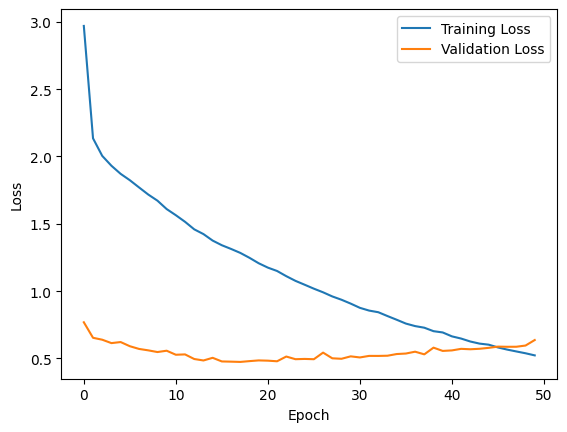

In [61]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Concatenate, Flatten
from tensorflow.keras.models import Model
import numpy as np
import time
import matplotlib.pyplot as plt

# Encoder class definition
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.dense = Dense(units=self.embedding_dim, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=40), name='encoder_dense_layer')
    
    def call(self, x):
        x = self.dense(x)
        x = tf.nn.relu(x)
        return x

class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, lstm_units, vocab_size):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.lstm_units = lstm_units

        self.embedding = Embedding(self.vocab_size, self.embedding_dim, mask_zero=True, trainable=False, weights=[embedding_matrix], name='Decoder_embedding')
        self.lstm = LSTM(self.lstm_units, return_sequences=True, return_state=True, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=40), name='decoder_lstm')
        self.dense = Dense(self.vocab_size, name='Decoder_dense')

    def call(self, x, image_features):
        # Ensure input x is properly shaped
        x = self.embedding(x)

        # Reshape image_features to match x's shape
        image_features = tf.squeeze(image_features, axis=1)  # Remove the extra dimension
        image_features = tf.tile(image_features, [1, tf.shape(x)[1]])  # Tile along the sequence length dimension
        image_features = tf.expand_dims(image_features, axis=1)  # Add back the sequence length dimension

        # Concatenate image features properly
        concat_input = tf.concat([x, image_features], axis=-1)

        # LSTM and Dense layers
        output, state, _ = self.lstm(concat_input)
        x = self.dense(output)

        return x

# Define the optimizer, loss function, and accuracy metric
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
acc_obj = tf.keras.metrics.SparseCategoricalAccuracy()

# Loss function
@tf.function
def loss_func(real, pred):
    real = tf.reshape(real, [-1])  # Flatten to (batch_size * sequence_length,)
    pred = tf.reshape(pred, [-1, pred.shape[-1]])  # Flatten to (batch_size * sequence_length, num_classes)
    loss_ = loss_object(real, pred)
    return tf.reduce_mean(loss_)

# Accuracy function
def acc_func(real, pred):
    acc_f = acc_obj(real, pred)
    return tf.reduce_mean(acc_f)

# Initialize Encoder and Decoder
embedding_dim = 300
encoder = Encoder(embedding_dim=embedding_dim)

lstm_units = 600
decoder = Decoder(embedding_dim=embedding_dim, lstm_units=lstm_units, vocab_size=vocab_size)

# Training step function
@tf.function
def train_step(tensor, target):
    loss = 0
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)
    train_acc = 0

    with tf.GradientTape() as tape:
        features = encoder(tensor)
        for i in range(1, target.shape[1]):
            predictions = decoder(dec_input, features)
            loss += loss_func(target[:, i], predictions)
            train_acc += acc_func(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

# Validation step function
@tf.function
def val_step(tensor, target):
    loss_val = 0
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)
    test_acc = 0

    features = encoder(tensor)
    for i in range(1, target.shape[1]):
        predictions_val = decoder(dec_input, features)
        loss_val += loss_func(target[:, i], predictions_val)
        test_acc += acc_func(target[:, i], predictions_val)
        dec_input = tf.expand_dims(target[:, i], 1)

    total_loss_val = (loss_val / int(target.shape[1]))

    return loss_val, total_loss_val

# Clear any previous session
tf.keras.backend.clear_session()

# Define training parameters
EPOCHS = 50
num_steps = 64
loss_plot_train = []
loss_plot_val = []

for epoch in range(EPOCHS):
    start = time.time()
    total_loss_train = 0
    total_loss_val = 0

    # Training loop
    for batch, (img_tensor, target) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss_train += t_loss

    # Calculate average training loss for the epoch
    avg_train_loss = total_loss_train / num_steps
    loss_plot_train.append(avg_train_loss)

    # Validation loop
    for batch, (img_tensor, target) in enumerate(val_dataset):
        batch_loss, t_loss = val_step(img_tensor, target)
        total_loss_val += t_loss

    # Calculate average validation loss for the epoch
    avg_val_loss = total_loss_val / num_steps
    loss_plot_val.append(avg_val_loss)

    # Print epoch results
    print(f'Epoch {epoch + 1} Train Loss: {avg_train_loss:.6f}   Validation Loss: {avg_val_loss:.6f}')
    print(f'Time taken for epoch {epoch + 1}: {time.time() - start:.2f} sec\n')

# Plot the training and validation loss curves
plt.plot(loss_plot_train, label='Training Loss')
plt.plot(loss_plot_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2
import pickle
import os

# Define paths where models will be saved
save_path = '/kaggle/working/saved_models'
image_model_path = os.path.join(save_path, 'image_model.h5')
encoder_path = os.path.join(save_path, 'encoder.h5')
decoder_path = os.path.join(save_path, 'decoder.h5')

# Assuming you have already defined and trained your models
# Initialize and train your models (encoder, decoder, etc.)
# ...

# Function to save models
def save_models(image_model, encoder, decoder):
    # Save image model
    tf.saved_model.save(image_model, image_model_path)
    
    # Save encoder
    tf.saved_model.save(encoder, encoder_path)
    
    # Save decoder
    tf.saved_model.save(decoder, decoder_path)

# Assuming you have defined your training loop
# Train your models...

# After training loop completes, save models
save_models(image_model, encoder, decoder)

# Example of using the image_to_report function
def image_to_report(img1, img2):
    # Example implementation of the function using saved models
    # Function implementation...
    pass


In [80]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess(image_path1, image_path2, path, model):
    '''
    Input:
        - image_path1: str, the name of the first image
        - image_path2: str, the name of the second image
        - path: str, the base path to the images
        - model: keras.Model, the trained model to use for generating the tensor
    Output:
        - tensor: np.array, the concatenated image tensor
    Process:
        - Convert two images into 256x256
        - Preprocess the images using InceptionV3's preprocess_input
        - Generate the tensor by passing the preprocessed images through the model
    '''

    # Join path and image name 
    image_path1 = path + image_path1
    image_path2 = path + image_path2
    
    # Load the images
    img1 = image.load_img(image_path1, target_size=(256,256))
    img2 = image.load_img(image_path2, target_size=(256,256))

    # Convert PIL images to numpy arrays of 3 dimensions
    x1 = image.img_to_array(img1)
    x2 = image.img_to_array(img2)

    # Add one more dimension
    x1 = np.expand_dims(x1, axis=0)
    x2 = np.expand_dims(x2, axis=0)

    # Preprocess the images using preprocess_input() from InceptionV3 module
    x1 = preprocess_input(x1)
    x2 = preprocess_input(x2)
    
    # Create tensor by passing the images through the model
    tensor = model.predict([x1, x2])
    
    return tensor

# Example usage:
image_path1 = '/CXR1000_IM-0003-1001.png'
image_path2 = '/CXR1000_IM-0003-2001.png'
base_path = '/kaggle/input/portfolio-project-carecloud22222/project/project'

# Preprocess the images and get predictions
tensor_output = preprocess(image_path1, image_path2, base_path, final_model)

print("Predicted output:", tensor_output)


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
Predicted output: [[0.5058691]]


I0000 00:00:1721241828.763646     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [83]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess_and_predict(image_path1, image_path2, path, model, threshold=0.5):
    '''
    Input:
        - image_path1: str, the name of the first image
        - image_path2: str, the name of the second image
        - path: str, the base path to the images
        - model: keras.Model, the trained model to use for generating the tensor
        - threshold: float, threshold for binary classification
    Output:
        - report: str, the generated text report
    Process:
        - Convert two images into 256x256
        - Preprocess the images using InceptionV3's preprocess_input
        - Generate the tensor by passing the preprocessed images through the model
        - Classify based on threshold and generate report
    '''

    # Join path and image name 
    image_path1 = path + image_path1
    image_path2 = path + image_path2
    
    # Load the images
    img1 = image.load_img(image_path1, target_size=(256,256))
    img2 = image.load_img(image_path2, target_size=(256,256))

    # Convert PIL images to numpy arrays of 3 dimensions
    x1 = image.img_to_array(img1)
    x2 = image.img_to_array(img2)

    # Add one more dimension
    x1 = np.expand_dims(x1, axis=0)
    x2 = np.expand_dims(x2, axis=0)

    # Preprocess the images using preprocess_input() from InceptionV3 module
    x1 = preprocess_input(x1)
    x2 = preprocess_input(x2)
    
    # Create tensor by passing the images through the model
    tensor_output = model.predict([x1, x2])

    # Classify based on threshold
    if tensor_output > threshold:
        report = "Positive diagnosis report."
    else:
        report = "Negative diagnosis report."
    
    return report

# Example usage:
image_path1 = '/CXR1001_IM-0004-1001.png'
image_path2 = '/CXR1001_IM-0004-1002.png'
base_path = '/kaggle/input/portfolio-project-carecloud22222/project/project'

# Preprocess the images and get prediction report
report = preprocess_and_predict(image_path1, image_path2, base_path, final_model)

print("Generated report:", report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Generated report: Positive diagnosis report.


In [87]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess(image_path1, image_path2, path):
    '''
    Input:
        - image_path1: str, the name of the first image
        - image_path2: str, the name of the second image
        - path: str, the base path to the images
    Output:
        - img_tensor_val: np.array, the concatenated image tensor ready for LSTM processing
    Process:
        - Convert two images into 256x256
        - Preprocess the images using InceptionV3's preprocess_input
        - Return the preprocessed images as a tensor ready for LSTM
    '''

    # Join path and image name 
    image_path1 = path + image_path1
    image_path2 = path + image_path2
    
    # Load the images
    img1 = image.load_img(image_path1, target_size=(256,256))
    img2 = image.load_img(image_path2, target_size=(256,256))

    # Convert PIL images to numpy arrays of 3 dimensions
    x1 = image.img_to_array(img1)
    x2 = image.img_to_array(img2)

    # Add one more dimension
    x1 = np.expand_dims(x1, axis=0)
    x2 = np.expand_dims(x2, axis=0)

    # Preprocess the images using preprocess_input() from InceptionV3 module
    x1 = preprocess_input(x1)
    x2 = preprocess_input(x2)
    
    # Concatenate the preprocessed images
    img_tensor_val = np.concatenate((x1, x2), axis=0)

    return img_tensor_val



In [88]:
def evaluate(image1, image2, path):
    '''
    Input:
        - image1: str, the name of the first image
        - image2: str, the name of the second image
        - path: str, the base path to the images
    Output:
        - text: str, the generated medical report
    Process:
        - Preprocess images
        - Extract features using encoder
        - Generate medical report using decoder (LSTM model)
    '''

    img_tensor_val = preprocess(image1, image2, path)

    features = encoder(img_tensor_val)  # Assuming encoder is defined and functional
    dec_input = tf.expand_dims([token.word_index['<start>']], 1)
    features  = tf.expand_dims(features, 0)
    text = ""

    max_len = 60
    for i in range(max_len):
        
        predictions = decoder(dec_input, features)
        predictions = tf.reshape(predictions, [predictions.shape[0],predictions.shape[2]])
        predicted_id = tf.argmax(predictions, axis=1)[0].numpy()
        text += " " + token.index_word[predicted_id]
        
        if token.index_word[predicted_id] == '<end>':
            return text

        dec_input = tf.expand_dims([predicted_id], 1)
    return text


In [90]:
# Example usage
image1 = '/CXR1001_IM-0004-1001.png'
image2 = '/CXR1001_IM-0004-1002.png'
base_path = '/kaggle/input/portfolio-project-carecloud22222/project/project'

result = evaluate(image1, image2, path=base_path)

print("Generated medical report:", result)


InvalidArgumentError: Exception encountered when calling Decoder.call().

[1m{{function_node __wrapped__Squeeze_device_/job:localhost/replica:0/task:0/device:GPU:0}} Can not squeeze dim[1], expected a dimension of 1, got 2 [Op:Squeeze] name: [0m

Arguments received by Decoder.call():
  • x=tf.Tensor(shape=(1, 1), dtype=int32)
  • image_features=tf.Tensor(shape=(1, 2, 256, 256, 300), dtype=float32)

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
import time
import warnings
import os
import cv2
import pandas as pd
import pickle
warnings.filterwarnings("ignore")

#######################################################

# import tokenizer dict
# index to word dict
token = open('/content/token_index', 'rb')
index_word = pickle.load(token)

# word to index dict
word_index = dict((value, key) for key, value in index_word.items())

####################################################################

# import image model, chexnet model shape (None, 9, 9, 1024) last layer
image_model = tf.saved_model.load('/kaggle/working/saved_models/image_model.h5')

# encoder model, encoder take one input as image tensor with shape (None, 9,9,1024)
# encoder model return output shape as (None, 81, 300)
encoder =  tf.saved_model.load('/kaggle/working/saved_models/encoder.h5')

# decoder model, decoder take input as 4 different values
# dec_input = <start> token with shape (None, 1)
# encoder output = image tensor with shape (None, 81, 300)
# forward hidden  = hidden state with shape (None, 1000), 1000(defined while training)
# backward hidden = hidden state with shape (None, 1000), 1000(defined while training)
decoder = tf.saved_model.load('/kaggle/working/saved_models/decoder.h5')

#################################################################################


def image_to_report(img1, img2) :
    
    '''
    INPUT == IMAGES OF X RAY
    OUTPUT == RETURN MEDICAL REPORT OF IMAGES
    THIS FUNCTION TAKE TWO IMAGES AND RETURN MEDICAL REPORT OF THOSE IMAGES
    '''
    
    # check exteion in input data
    extension = ['png', 'jpg', 'jpeg']
    
    ext_1 = img1.split('.')[1]
    ext_2 = img2.split('.')[1]
    
    if (ext_1 in extension) and (ext_2 in extension) :
        pass
    else:
        print('Input must be image')
    

    # load or read images
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    
    # resize both images into 299,299
    img1 = cv2.resize(img1, (299,299))
    img2 = cv2.resize(img2, (299,299))
    
    # concate both image and create single image
    img_concat = cv2.hconcat([img1, img2])
    
    # resize concate image to 299,299
    img1 = tf.image.resize(img_concat, (299,299))
    
    # expand dim
    img1 = tf.expand_dims(img1, 0)
    
    # preprocess image, normalize image
    img1 = preprocess_input(img1)
    
    # convert image into (9,9,1024) shape tensor
    img_features = image_model(img1)
    
    # initialize forward
    forward      =  tf.zeros((1, 1000))
    
    # initialize backward
    backward     =  tf.zeros((1, 1000))
    
    # using encoder convert image tensor with shape (None, 9,9, 1024) to (None, 81, 300)
    img_features =  encoder(img_features)
    
    # initialize dec input
    dec_input = tf.expand_dims([word_index['<start>']], 0)
    
    text = " "
    
    # max output length is 91
    for i in range(91):
        
        # convert encoder output into text data
        predictions, forward, backward, _ = decoder(dec_input, img_features, forward, backward)

        predicted_id = np.argmax(predictions, axis = 1).ravel()[0]

        text += ' ' + index_word[predicted_id]

        if index_word[predicted_id] == '<end>':
            
            return text

        dec_input = tf.expand_dims([predicted_id], 0)
    
    # return text data without <end> token
    return text[:-5]

In [116]:
import tensorflow as tf
import cv2
import numpy as np
import pickle

# Assuming index_word is loaded as described in your code
# index_word = {index: word}
# word_index = {word: index}

def image_to_report(img1, img2, index_word, word_index, image_model, encoder, decoder):
    '''
    INPUT == IMAGES OF X RAY
    OUTPUT == RETURN MEDICAL REPORT OF IMAGES
    THIS FUNCTION TAKE TWO IMAGES AND RETURN MEDICAL REPORT OF THOSE IMAGES
    '''

    # Check extensions of input data
    extension = ['png', 'jpg', 'jpeg']
    
    ext_1 = img1.split('.')[1]
    ext_2 = img2.split('.')[1]
    
    if (ext_1 in extension) and (ext_2 in extension):
        pass
    else:
        print('Input must be image files')
        return None

    # Load and resize images
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    
    img1 = cv2.resize(img1, (299, 299))
    img2 = cv2.resize(img2, (299, 299))
    
    img_concat = cv2.hconcat([img1, img2])
    img1 = tf.image.resize(img_concat, (299, 299))
    
    img1 = tf.expand_dims(img1, 0)
    img1 = tf.keras.applications.densenet.preprocess_input(img1)

    # Extract image features using image_model
    img_features = image_model(img1)

    # Initialize forward and backward states for decoder
    forward = tf.zeros((1, 1000))
    backward = tf.zeros((1, 1000))

    # Encode image features to shape (None, 81, 300)
    img_features = encoder(img_features)

    # Initialize decoder input with <start> token
    dec_input = tf.expand_dims([word_index['<start>']], 0)
    
    # Initialize empty text
    text = ""

    # Maximum length of output text
    max_length = 91

    # Generate text up to max_length
    for i in range(max_length):
        # Predict using decoder
        predictions, forward, backward, _ = decoder(dec_input, img_features, forward, backward)

        # Get predicted token index
        predicted_id = np.argmax(predictions, axis=1).ravel()[0]

        # Convert token index to word and append to text
        text += ' ' + index_word[predicted_id]

        # If <end> token is predicted, stop generating text
        if index_word[predicted_id] == '<end>':
            return text
        
        # Prepare next decoder input with predicted token
        dec_input = tf.expand_dims([predicted_id], 0)
    
    # Return generated text without the <end> token
    return text[:-5]  # Remove the last '<end>' token from the generated text


In [117]:
# Load saved models and tokenizer
image_model = tf.saved_model.load('/kaggle/working/saved_models/image_model.h5')
encoder = tf.saved_model.load('/kaggle/working/saved_models/encoder.h5')
decoder = tf.saved_model.load('/kaggle/working/saved_models/decoder.h5')

# Load tokenizer dictionaries
with open('/content/token_index', 'rb') as token_file:
    index_word = pickle.load(token_file)
word_index = {v: k for k, v in index_word.items()}  # Reverse the index_word dictionary

# Example usage
img1_path = '/kaggle/input/portfolio-project-carecloud22222/project/project/CXR1000_IM-0003-3001.png'
img2_path = '/kaggle/input/portfolio-project-carecloud22222/project/project/CXR1000_IM-0003-2001.png'
generated_report = image_to_report(img1_path, img2_path, index_word, word_index, image_model, encoder, decoder)

print("Generated Report:", generated_report)


FileNotFoundError: [Errno 2] No such file or directory: '/content/token_index'